# STATISTIC MODELLING OF ATTACKS FINISHED WITH A CROSS IN FOOTBALL MATCHES

This project will focus on analysing crosses made in Premier League 2015/2016 season, especially those that led to a shot on goal. I will check which teams and which players had the most effective crosses and what characteristics of a cross have the biggest impact on its accuracy and final outcome.

Using machine learning, I will try to predict the outcome of a cross based only on its characteristics like coordinates, height, angle etc.

Data used for this project comes from StatsBomb webiste and is part of free available data they posted for 2015/2016 season. For my analysis, I will be using event data which is collection of events happening during each game of 2015/2016 season in Premier League. Every pass, dribble, shot or faul is treated as an event and is described using certain variables like timestamp, coordinates or player name. Each event type has its own characterstics specific for this type only. For example each pass has lenght, height and angle variables.

In this project (apart from typical data science libraries) I will be using mplsoccer library, which is a Python library for plotting football charts in Matplotlib and loading StatsBomb open-data.

## Preparing the dataset

The main dataset that I will be working on should contain all events from every game of Premier League 2015/2016 season. To prepare it, I need to first get the list of competitions available in StatsBomb data, get the list of games in Premier League 2015/2016 season, get the event data for each game and join them into one dataframe. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#Sbopen to access the data from StatsBomb, Pitch and Vertical Pitch for plotting
from mplsoccer import Pitch, Sbopen, VerticalPitch

In [2]:
#access the free available data from StatsBomb
parser = Sbopen()
#check all available competitions and seasons
df = parser.competition()
#check competition_id and season_id for Premier League 2015/2016 season
df[df['competition_name']=='Premier League']

competition_id  season_id country_name competition_name  \
63               2         27      England   Premier League   
64               2         44      England   Premier League   

   competition_gender  competition_youth  competition_international  \
63               male              False                      False   
64               male              False                      False   

   season_name               match_updated        match_updated_360  \
63   2015/2016  2024-01-25T11:45:53.333860  2021-06-13T16:17:31.694   
64   2003/2004  2024-03-08T14:49:13.195793  2021-06-13T16:17:31.694   

   match_available_360             match_available  
63                None  2024-01-25T11:45:53.333860  
64                None  2024-03-08T14:49:13.195793

Premier League 2015/2016 season has competition id = 2 and season id = 27

In [3]:
parser = Sbopen()
#check all games from Premier League 2015/2016 season
df = parser.match(2,27)
df.head()

match_id match_date            kick_off  home_score  away_score  \
0   3754058 2016-01-02 2016-01-02 16:00:00           0           0   
1   3754245 2015-10-17 2015-10-17 16:00:00           1           0   
2   3754136 2015-12-19 2015-12-19 18:30:00           1           1   
3   3754037 2016-04-30 2016-04-30 16:00:00           2           1   
4   3754039 2016-02-13 2016-02-13 16:00:00           1           2   

  match_status match_status_360               last_updated  \
0    available       processing 2021-10-29 23:44:19.940296   
1    available        scheduled 2022-12-01 13:09:17.044015   
2    available        scheduled 2020-11-12 23:48:19.757269   
3    available       processing 2021-07-07 17:59:57.456000   
4    available       processing 2021-07-25 18:09:51.386000   

         last_updated_360  match_week  ...  competition_stage_id  \
0 2021-06-12 16:17:31.694          20  ...                     1   
1 2021-06-13 16:17:31.694           9  ...                     1   
2 2021-06-13 16:17:31.694          17  ...                     1   
3 2021-06-12 16:17:31.694          36  ...                     1   
4 2021-06-12 16:17:31.694          26  ...                     1   

  competition_stage_name stadium_id         stadium_name stadium_country_id  \
0         Regular Season         20  King Power Stadium                  68   
1         Regular Season         33        The Hawthorns                 68   
2         Regular Season       4674     St. James'' Park                 68   
3         Regular Season         12        Goodison Park                 68   
4         Regular Season         37        Selhurst Park                 68   

   stadium_country_name referee_id     referee_name referee_country_id  \
0               England          5   Andre Marriner                 68   
1               England          4  Martin Atkinson                 68   
2               England          4  Martin Atkinson                 68   
3               England          7   Neil Swarbrick                 68   
4               England          9    Robert Madley                 68   

   referee_country_name  
0               England  
1               England  
2               England  
3               England  
4               England  

[5 rows x 52 columns]

In [4]:
#create a list of games and validate if all games are included (season has 38 gameweeks, 10 games in each gameweek)
games_list = list(df['match_id'])
len(games_list)

380

In [5]:
parser = Sbopen()
#get events from one game and check what are the columns
df, related, freeze, tactics = parser.event(3754037)
col=df.columns
col

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'match_id', 'type_id', 'type_name', 'possession_team_id',
       'possession_team_name', 'play_pattern_id', 'play_pattern_name',
       'team_id', 'team_name', 'tactics_formation', 'player_id', 'player_name',
       'position_id', 'position_name', 'pass_recipient_id',
       'pass_recipient_name', 'pass_length', 'pass_angle', 'pass_height_id',
       'pass_height_name', 'end_x', 'end_y', 'body_part_id', 'body_part_name',
       'sub_type_id', 'sub_type_name', 'x', 'y', 'outcome_id', 'outcome_name',
       'under_pressure', 'out', 'off_camera', 'pass_cross', 'pass_switch',
       'counterpress', 'ball_recovery_recovery_failure',
       'pass_assisted_shot_id', 'pass_goal_assist', 'shot_statsbomb_xg',
       'end_z', 'shot_key_pass_id', 'technique_id', 'technique_name',
       'goalkeeper_position_id', 'goalkeeper_position_name', 'pass_cut_back',
       'aerial_won', 'foul_won_defensive', 'p

In [6]:
#based on the columns for match_id 3754037, create a list of fields required for analysis
required_columns = ['index','period', 'minute', 'second', 'possession',
       'duration', 'match_id', 'type_id', 'type_name', 'possession_team_id',
       'possession_team_name', 'play_pattern_name','team_name', 'player_name','position_name',
                   'pass_recipient_name', 'pass_length', 'pass_angle',
       'pass_height_name', 'end_x', 'end_y','body_part_name','sub_type_name', 'x', 'y','outcome_name','under_pressure',
                   'pass_cross', 'pass_switch',
       'counterpress', 'ball_recovery_recovery_failure', 'shot_statsbomb_xg',
       'end_z', 'shot_key_pass_id','technique_name','goalkeeper_position_name',
       'aerial_won', 'foul_won_defensive', 'pass_shot_assist']

Below function will go across all events in each game and check if the event occured 3 or less seconds before the goal was scored. Such event will be treated as "leading to goal". New column will be added to each such event with a tuple containing 4 elemets - period, shot outcome, time in seconds and match_id. From these events I will later extract only crosses. Processed events from every game will be then joined together in one dataframe.

Because this step takes more than 2 hours, I will later save this dataframe as csv to not have to repeat it later.

If a player from team X makes a cross and less than 3 seconds later a goal is scored, I will assume that the scoring team is team X. 3 seconds should not be enough for the other team to intercept a ball and score.

Period 1 always starts at 00:00 and period 2 at 45:00. Because both periods of the game last 45 minutes + added time, the function will check events in period 1 and period 2 separately. If the goal was scored at 46:20 in period 1 (because there were 2 minutes of added time), event that took place at 46:18 in period 2 should not be classified as "leading to goal".

In [7]:
def check_if_leads_to_shot(row):
    for period in [1,2]:
        #for each shot in the game, the function will check if any events occured 3 or less seconds before a shot was made
        for i in range(0,len(shots_list)):
            if row['period'] == period and row['time'] in range(shots_list[i][2]-3,shots_list[i][2]):
                return (shots_list[i])

In [8]:
#create an empty dataframe with required columns
df_all=pd.DataFrame(columns=required_columns)
#loop to go through every game in the list of games in Premier League 2015/16 season
for i in games_list:
    parser = Sbopen()
    #generate list of events for a game
    df, related, freeze, tactics = parser.event(i)
    #get only required columns
    df = df[required_columns]
    #add column "time" with time in seconds
    df['time']=(df['minute']*60+df['second'])
    df.reset_index(inplace=True)
    #get the list of shots in the game. The list will consist of tuples with 4 elements to describe each shot.
    df_shots = df[df['type_name']=='Shot'][['match_id','period','time','outcome_name']]
    shots_list = list(zip(df_shots['period'].to_list(),df_shots['outcome_name'].to_list(),df_shots['time'].to_list(),
                     df_shots['match_id'].to_list()))
    #add new column to the dataframe by applying check_if_leads_to_shot function
    df['leads_to_shot'] = df.apply(check_if_leads_to_shot,axis=1)
    #processed dataframe is merged with all previously processed dataframes to create one dataframe with events for all games
    df_all = pd.concat([df_all,df],ignore_index=True)

In [9]:
#check all crosses classified as leading to shot
df_all[(df_all['pass_cross'] == True) & (df_all['leads_to_shot'].notna())]['leads_to_shot']

436           (1, Off T, 560, 3754058)
576           (1, Off T, 791, 3754058)
1599         (1, Off T, 2217, 3754058)
3000         (2, Off T, 4536, 3754058)
5001         (1, Saved, 2569, 3754245)
                      ...             
1306199    (2, Blocked, 4847, 3754141)
1306485      (2, Off T, 5310, 3754141)
1307668      (1, Off T, 1175, 3754128)
1308791      (2, Saved, 2848, 3754128)
1311488      (1, Saved, 1693, 3754078)
Name: leads_to_shot, Length: 1623, dtype: object

Based on our processing, there were 1623 crosses leading to a shot on goal in the entire season. This number seems reasonable, the average number of crosses leading to shot per game would be 4.

In [10]:
#df_all.to_csv(r'C:\\Users\\ADMIN\\Desktop\\Python\\crosses_new.csv')

In [11]:
#df_all = pd.read_csv('C:\\Users\\ADMIN\\Desktop\\Python\\crosses_new.csv')

In [12]:
#create a cross_outcome column from leads_to_shot tuple
df_all['cross_outcome'] = df_all['leads_to_shot'].apply(lambda x:x[1] if x != None else x)
#if cross_outcome is blank it means that the event did not lead to shot
df_all['cross_outcome'].fillna('No shot',inplace=True)
df_all['cross_outcome'].value_counts()

No shot             1283644
Off T                  9347
Blocked                9112
Saved                  6751
Goal                   3042
Wayward                1131
Post                    567
Saved Off Target        137
Saved to Post            52
Name: cross_outcome, dtype: int64

Some of these outcomes are very rare and it would be difficult to come to any conclusions for them. I will leave only 5 most populat oucomes and the others will be added either to Off Target or Saved

In [13]:
df_all['cross_outcome'][(df_all['cross_outcome'] == 'Saved to Post') | (df_all['cross_outcome'] == 'Saved Off Target')] = 'Saved'

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12224\358824758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['cross_outcome'][(df_all['cross_outcome'] == 'Saved to Post') | (df_all['cross_outcome'] == 'Saved Off Target')] = 'Saved'


In [14]:
df_all['cross_outcome'][(df_all['cross_outcome'] == 'Wayward') | (df_all['cross_outcome'] == 'Post')] = 'Off T'

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12224\693866195.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['cross_outcome'][(df_all['cross_outcome'] == 'Wayward') | (df_all['cross_outcome'] == 'Post')] = 'Off T'


In [15]:
df_all['cross_outcome'].value_counts()

No shot    1283644
Off T        11045
Blocked       9112
Saved         6940
Goal          3042
Name: cross_outcome, dtype: int64

In [16]:
#create a new dataframe only with crosses
df_crosses = df_all[df_all['pass_cross'] == True]
df_crosses['cross_outcome'].value_counts()

No shot    7922
Off T       726
Blocked     370
Saved       298
Goal        229
Name: cross_outcome, dtype: int64

## Graphical analysis

First I will make a few basic graphs to present the different variables like pass length, position name, pass height name and play patter name.

<AxesSubplot:xlabel='pass_length', ylabel='Count'>

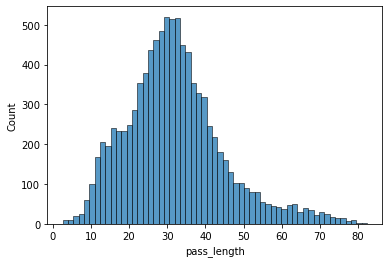

In [17]:
sns.histplot(df_crosses['pass_length'])

<AxesSubplot:xlabel='count', ylabel='position_name'>

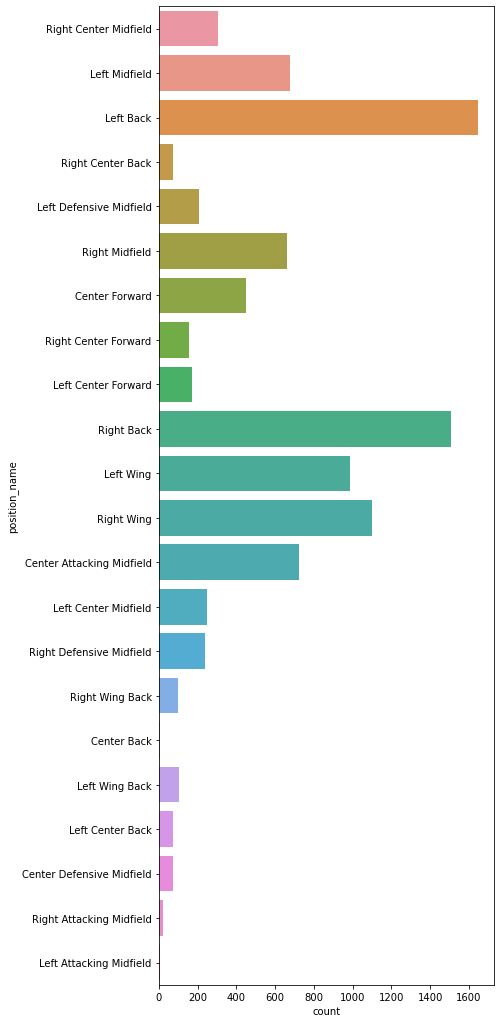

In [18]:
plt.figure(figsize=(6,18))
sns.countplot(y='position_name',data=df_crosses,orient='h')

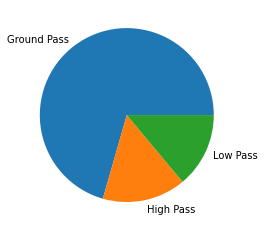

In [19]:
plt.pie(df_crosses['pass_height_name'].value_counts(),labels=df_crosses['pass_height_name'].unique())
plt.show()

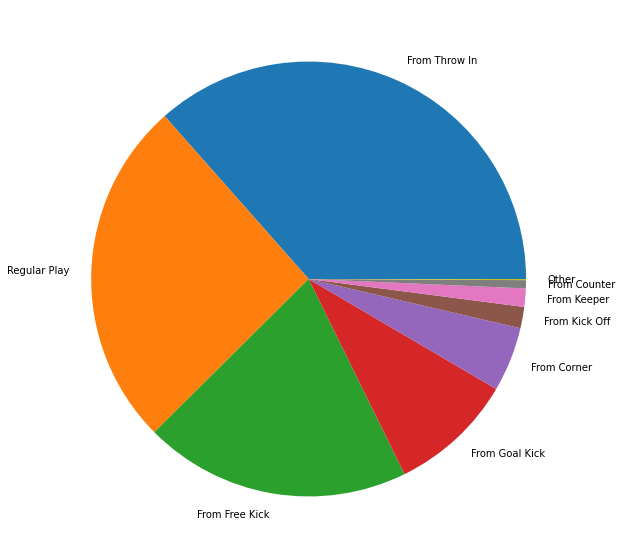

In [20]:
plt.figure(figsize=(10,10))
plt.pie(df_crosses['play_pattern_name'].value_counts(),labels=df_crosses['play_pattern_name'].unique())
plt.show()

Above graphs show basic characteristics of crosses. Most frequent pass length is between 20 and 40 metres. Crosses are mostly made by full backs or wingers. Most crosses are ground passes. Very often cross comes shortly after a throw in or free kick.

I will compare outcome of the crosses that lead do a shot made by each team. Crosses are divided into 4 categories - Shot Off Target, Saved by the goalkeeper, Blocked by the defender and Goal.

In [21]:
#group by teams and count values for each cross_outcome
df_crosses_teams = df_crosses.groupby('team_name')
df_crosses_teams['cross_outcome'].value_counts()

team_name        cross_outcome
AFC Bournemouth  No shot          392
                 Off T             42
                 Blocked           15
                 Goal              15
                 Saved             12
                                 ... 
West Ham United  No shot          379
                 Off T             45
                 Goal              19
                 Saved             19
                 Blocked           15
Name: cross_outcome, Length: 100, dtype: int64

<AxesSubplot:xlabel='count', ylabel='team_name'>

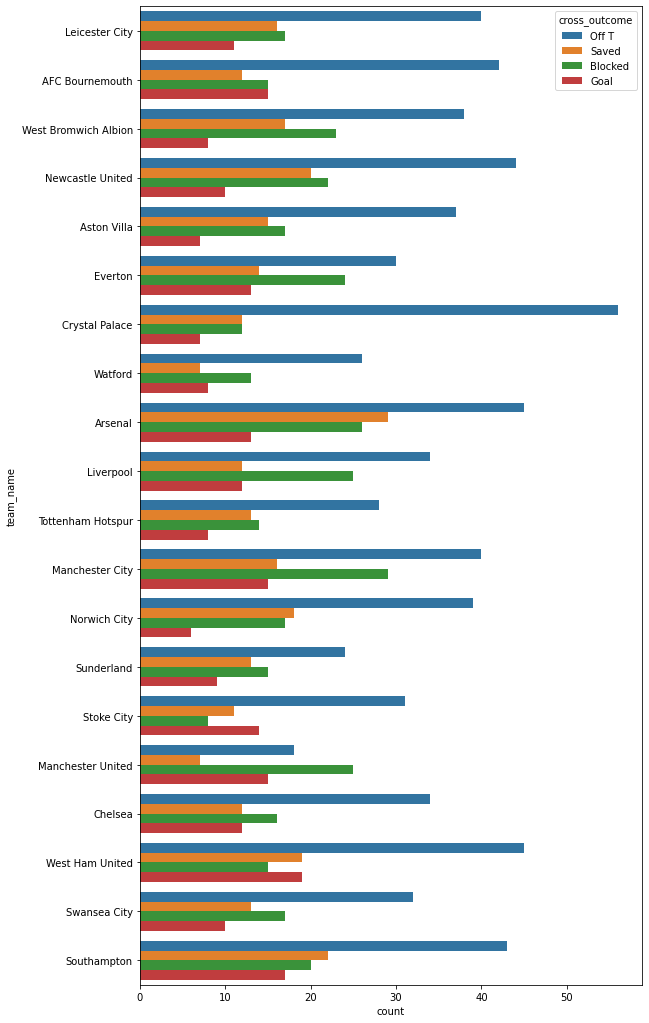

In [22]:
#plot horizontally for each team showing crosses that lead to a shot
plt.figure(figsize=(9,18))
sns.countplot(y='team_name', data=df_crosses[df_crosses['cross_outcome']!='No shot'], hue='cross_outcome', orient='h')

Based on this I see which teams have a higher accuracy from crosses and find a few teams with interesting statistics:
- Manchester United has the lowest number of shots off target and saved but a lot of their shots are blocked
- Crystal Palace has a lot of shots from crosses but a lot of them are off target compared to other teams
- Arsenal scored a lot of goals from crosses but they are also in top 3 teams for shots off target, saved and blocked. So their results could have been even better if their strikers had better accuracy.
- West Ham, Stoke City and Bournemouth are the only teams with more goals scored than shots saved and blocked. Their strikers have a really high accuracy.

In the next step I will calculate the average cross conversion i.e. how many crosses each team needed to score a goal. Based on this, I will divide teams into three categories (Below Average, Average and Above Average) and present the findings on a graph.

In [23]:
#get the count for each team and each cross_outcome
teams = df_crosses[['team_name','cross_outcome']].groupby('team_name').value_counts().reset_index()
#move team_name to index and cross_outcome to columns
crosses_per_teams = teams.pivot(index=teams.columns[0],columns=teams.columns[1],values=teams.columns[2])
#get the total number of crosses per team
crosses_per_teams['Sum']=crosses_per_teams['Blocked']+crosses_per_teams['No shot']+crosses_per_teams['Goal']+crosses_per_teams['Off T']+crosses_per_teams['Saved']
#create new column with crosses efficiency for each team
crosses_per_teams['Cross_efficiency'] = crosses_per_teams['Goal']/crosses_per_teams['Sum']*100
crosses_per_teams.sort_values('Cross_efficiency',inplace=True)
crosses_per_teams

cross_outcome         Blocked  Goal  No shot  Off T  Saved  Sum  \
team_name                                                         
Norwich City               17     6      427     39     18  507   
Crystal Palace             12     7      470     56     12  557   
Aston Villa                17     7      410     37     15  486   
West Bromwich Albion       23     8      376     38     17  462   
Tottenham Hotspur          14     8      368     28     13  431   
Watford                    13     8      343     26      7  397   
Newcastle United           22    10      379     44     20  475   
Leicester City             17    11      432     40     16  516   
Swansea City               17    10      370     32     13  442   
Liverpool                  25    12      428     34     12  511   
Chelsea                    16    12      385     34     12  459   
Arsenal                    26    13      363     45     29  476   
Sunderland                 15     9      268     24     13  329   
Everton                    24    13      392     30     14  473   
Manchester City            29    15      440     40     16  540   
Southampton                20    17      504     43     22  606   
Manchester United          25    15      456     18      7  521   
AFC Bournemouth            15    15      392     42     12  476   
Stoke City                  8    14      340     31     11  404   
West Ham United            15    19      379     45     19  477   

cross_outcome         Cross_efficiency  
team_name                               
Norwich City                  1.183432  
Crystal Palace                1.256732  
Aston Villa                   1.440329  
West Bromwich Albion          1.731602  
Tottenham Hotspur             1.856148  
Watford                       2.015113  
Newcastle United              2.105263  
Leicester City                2.131783  
Swansea City                  2.262443  
Liverpool                     2.348337  
Chelsea                       2.614379  
Arsenal                       2.731092  
Sunderland                    2.735562  
Everton                       2.748414  
Manchester City               2.777778  
Southampton                   2.805281  
Manchester United             2.879079  
AFC Bournemouth               3.151261  
Stoke City                    3.465347  
West Ham United               3.983229

In [24]:
# crosses_per_teams.to_csv(r'C:\\Users\\ADMIN\\Desktop\\Python\\crosses_per_teams.csv')

In [25]:
# crosses_per_teams = pd.read_csv('C:\\Users\\ADMIN\\Desktop\\Python\\crosses_per_teams.csv')

In [26]:
#change column names to be more accurate
crosses_per_teams.rename(columns={'Sum':'Total number of Crosses',
                                 'Goal':'Goals from Crosses'}, inplace=True)

#create new column to show the proportion of goals per cross
crosses_per_teams['Goals/Crosses'] = crosses_per_teams['Goals from Crosses']/crosses_per_teams['Total number of Crosses']
crosses_per_teams

cross_outcome         Blocked  Goals from Crosses  No shot  Off T  Saved  \
team_name                                                                  
Norwich City               17                   6      427     39     18   
Crystal Palace             12                   7      470     56     12   
Aston Villa                17                   7      410     37     15   
West Bromwich Albion       23                   8      376     38     17   
Tottenham Hotspur          14                   8      368     28     13   
Watford                    13                   8      343     26      7   
Newcastle United           22                  10      379     44     20   
Leicester City             17                  11      432     40     16   
Swansea City               17                  10      370     32     13   
Liverpool                  25                  12      428     34     12   
Chelsea                    16                  12      385     34     12   
Arsenal                    26                  13      363     45     29   
Sunderland                 15                   9      268     24     13   
Everton                    24                  13      392     30     14   
Manchester City            29                  15      440     40     16   
Southampton                20                  17      504     43     22   
Manchester United          25                  15      456     18      7   
AFC Bournemouth            15                  15      392     42     12   
Stoke City                  8                  14      340     31     11   
West Ham United            15                  19      379     45     19   

cross_outcome         Total number of Crosses  Cross_efficiency  Goals/Crosses  
team_name                                                                       
Norwich City                              507          1.183432       0.011834  
Crystal Palace                            557          1.256732       0.012567  
Aston Villa                               486          1.440329       0.014403  
West Bromwich Albion                      462          1.731602       0.017316  
Tottenham Hotspur                         431          1.856148       0.018561  
Watford                                   397          2.015113       0.020151  
Newcastle United                          475          2.105263       0.021053  
Leicester City                            516          2.131783       0.021318  
Swansea City                              442          2.262443       0.022624  
Liverpool                                 511          2.348337       0.023483  
Chelsea                                   459          2.614379       0.026144  
Arsenal                                   476          2.731092       0.027311  
Sunderland                                329          2.735562       0.027356  
Everton                                   473          2.748414       0.027484  
Manchester City                           540          2.777778       0.027778  
Southampton                               606          2.805281       0.028053  
Manchester United                         521          2.879079       0.028791  
AFC Bournemouth                           476          3.151261       0.031513  
Stoke City                                404          3.465347       0.034653  
West Ham United                           477          3.983229       0.039832

In the next step, I will create a function to assign cross conversion class based on the cross conversion value and the average value for all teams.

In [31]:
#calculate average cross_conversion value
cross_conversion = crosses_per_teams['Goals/Crosses'].mean()

def assign_cross_conversion_class(x):
    treshold = 0.15
    if x < cross_conversion*(1-treshold):
        return 'Below Average'
    elif x > cross_conversion*(1+treshold):
        return 'Above Average'
    else:
        return 'Average'
    
#add new column with cross conversion class calculated by the function
crosses_per_teams['Cross conversion'] = crosses_per_teams['Goals/Crosses'].apply(lambda x:assign_cross_conversion_class(x))

crosses_per_teams.reset_index(inplace=True)
crosses_per_teams

cross_outcome             team_name  Blocked  Goals from Crosses  No shot  \
0                      Norwich City       17                   6      427   
1                    Crystal Palace       12                   7      470   
2                       Aston Villa       17                   7      410   
3              West Bromwich Albion       23                   8      376   
4                 Tottenham Hotspur       14                   8      368   
5                           Watford       13                   8      343   
6                  Newcastle United       22                  10      379   
7                    Leicester City       17                  11      432   
8                      Swansea City       17                  10      370   
9                         Liverpool       25                  12      428   
10                          Chelsea       16                  12      385   
11                          Arsenal       26                  13      363   
12                       Sunderland       15                   9      268   
13                          Everton       24                  13      392   
14                  Manchester City       29                  15      440   
15                      Southampton       20                  17      504   
16                Manchester United       25                  15      456   
17                  AFC Bournemouth       15                  15      392   
18                       Stoke City        8                  14      340   
19                  West Ham United       15                  19      379   

cross_outcome  Off T  Saved  Total number of Crosses  Cross_efficiency  \
0                 39     18                      507          1.183432   
1                 56     12                      557          1.256732   
2                 37     15                      486          1.440329   
3                 38     17                      462          1.731602   
4                 28     13                      431          1.856148   
5                 26      7                      397          2.015113   
6                 44     20                      475          2.105263   
7                 40     16                      516          2.131783   
8                 32     13                      442          2.262443   
9                 34     12                      511          2.348337   
10                34     12                      459          2.614379   
11                45     29                      476          2.731092   
12                24     13                      329          2.735562   
13                30     14                      473          2.748414   
14                40     16                      540          2.777778   
15                43     22                      606          2.805281   
16                18      7                      521          2.879079   
17                42     12                      476          3.151261   
18                31     11                      404          3.465347   
19                45     19                      477          3.983229   

cross_outcome  Goals/Crosses Cross conversion  
0                   0.011834    Below Average  
1                   0.012567    Below Average  
2                   0.014403    Below Average  
3                   0.017316    Below Average  
4                   0.018561    Below Average  
5                   0.020151    Below Average  
6                   0.021053          Average  
7                   0.021318          Average  
8                   0.022624          Average  
9                   0.023483          Average  
10                  0.026144          Average  
11                  0.027311          Average  
12                  0.027356          Average  
13                  0.027484          Average  
14                  0.027778    Above Average  
15                  0.028053    Above Average  
16         

I will present my findings on the scatterplot. For each team, the plot will compare Total Number of Crosses and number of Goals Scored From Crosses. On the plot I will also add the average cross conversion rate and divide the teams into three categories based on the cross conversion class

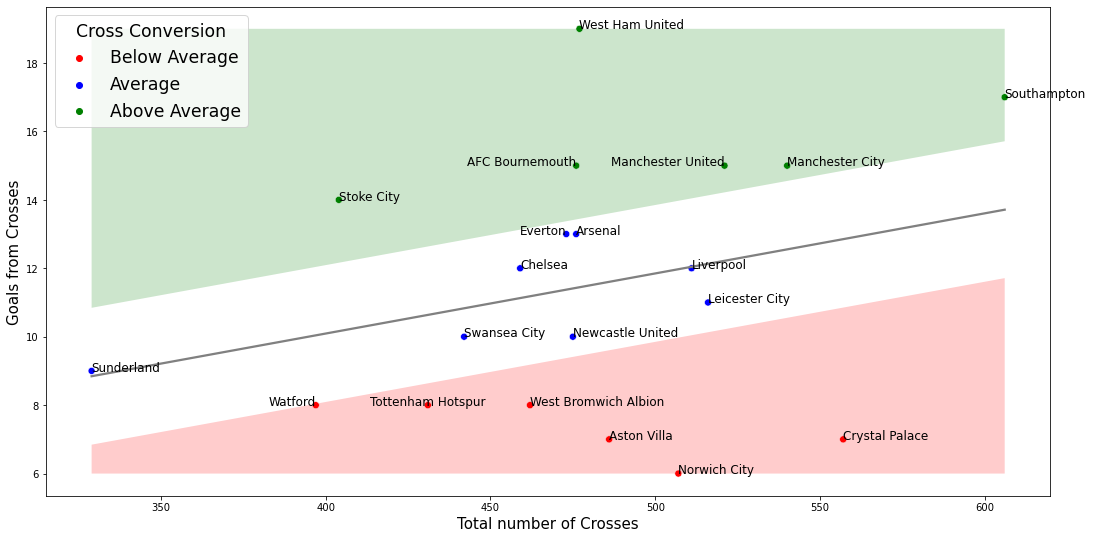

In [32]:
fig, ax = plt.subplots(figsize=(18, 9))

x = crosses_per_teams['Total number of Crosses']
y = crosses_per_teams['Goals from Crosses']
z = crosses_per_teams['Cross conversion']

#scatterplot
p1 = sns.scatterplot(x=x,y=y,s=50,hue=z,palette=['red','blue','green'],data=crosses_per_teams)
#loop to add annotations
#some team names were overlapping so their annotations will be manually moved by changing their text alignment
for index,row in crosses_per_teams.iterrows():
    if row['team_name'] in ['AFC Bournemouth','Manchester United','Everton','Watford']:
        p1.text(row['Total number of Crosses'],row['Goals from Crosses'],row['team_name'],size='large',ha='right')
    elif row['team_name'] == 'Tottenham Hotspur':
        p1.text(row['Total number of Crosses'],row['Goals from Crosses'],row['team_name'],size='large',ha='center')
    else:
        p1.text(row['Total number of Crosses'],row['Goals from Crosses'],row['team_name'],size='large',ha='left')

#regression line
p2 = sns.regplot(x=x,y=y,ci = None,scatter=False,color='grey',data=crosses_per_teams)

#get the regression line coordinates
reg_line_x = np.linspace(x.min(), x.max(), 100)
reg_line_y = np.poly1d(np.polyfit(x, y, 1))(reg_line_x)

#create a polygon for filling under regplot
fill_x_under = np.append(reg_line_x, reg_line_x[::-1])
fill_y_under = np.append(reg_line_y-2, np.repeat(y.min(), len(reg_line_y)))

#create a polygon for filling above regplot
fill_x_above = np.append(reg_line_x, reg_line_x[::-1])
fill_y_above = np.append(reg_line_y+2, np.repeat(y.max(), len(reg_line_y)))

#fill above the regression line
plt.fill(fill_x_above, fill_y_above, 'green', alpha=0.2)

#fill under the regression line
plt.fill(fill_x_under, fill_y_under, 'red', alpha=0.2)

plt.xlabel("Total number of Crosses", fontsize=15)
plt.ylabel("Goals from Crosses", fontsize=15)

legend = plt.legend(fontsize='xx-large',loc='upper left',title='Cross Conversion',title_fontsize='xx-large')

This graph confirms some of the findings from the previous one. Crystal Palace is second in total number of crosses but their cross conversion is among the worst in the league. West Ham has the best cross conversion by far. Sothampton made the most crosses but it was justified. Their cross converstion is above average and second to West Ham only.

In the next graph, I will check players that made the most crosses, players that received the most crosses and check if there were players that were above average in both these categories

In [33]:
#get the names of players making and receiving crosses
df_crosses = df_all[['player_name','pass_recipient_name']][df_all['pass_cross']==True]

#get list of crosses made per player
df_crosses_made = df_crosses.groupby('player_name').count()

#get list of crosses received per player
df_crosses_received = df_crosses.groupby('pass_recipient_name').count()

In [34]:
#get 200 players with most crosses made and count average among them
df_crosses_made.sort_values(by='pass_recipient_name',ascending=False,inplace=True)
avg_crosses_made = df_crosses_made.iloc[:200]['pass_recipient_name'].mean()
df_crosses_made = df_crosses_made.iloc[:200]
df_crosses_made.reset_index(inplace=True)

#get 200 players with most crosses received and count average among them
df_crosses_received.sort_values(by='player_name',ascending=False,inplace=True)
avg_crosses_received = df_crosses_received.iloc[:200]['player_name'].mean()
df_crosses_received = df_crosses_received.iloc[:200]
df_crosses_received.reset_index(inplace=True)

In [35]:
#update to more adequate column names
df_crosses_made.rename(columns={'player_name':'player','pass_recipient_name':'crosses made'},inplace=True)
df_crosses_received.rename(columns={'pass_recipient_name':'player','player_name':'crosses received'},inplace=True)

In [36]:
#create one dataframe from crosses_made and crosses_received
df_crosses_made_and_received = pd.merge(df_crosses_made, df_crosses_received, on="player")

In [37]:
print(avg_crosses_received)

30.83


I will generate scatterplot comparing number of crosses made and received by players who were in top 200 in one of these classifications. The graph will also show the average number of crosses made and received and identify the players who are the best in each category but also those who are above average in both.

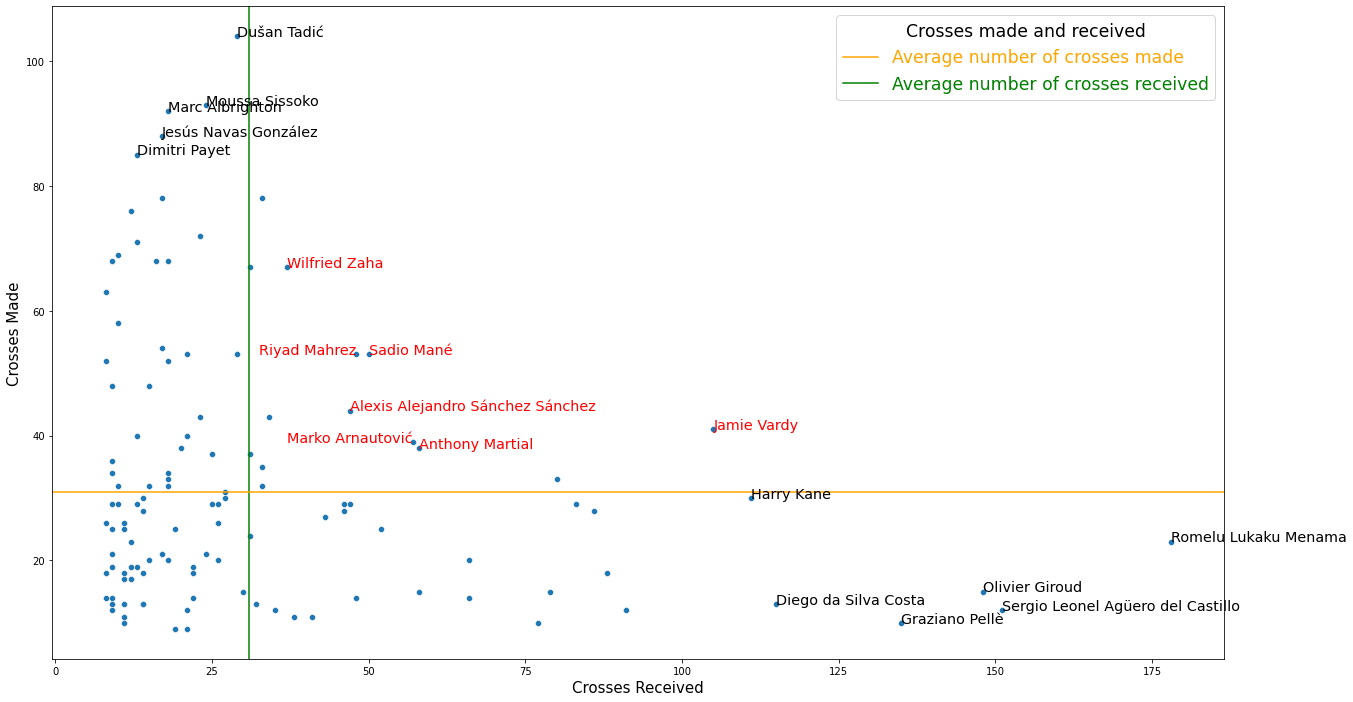

In [38]:
fig, ax = plt.subplots(figsize=(21, 12))

#scatterplot showing crosses received and made
p1 = sns.scatterplot(x='crosses received',y='crosses made',data=df_crosses_made_and_received)

#loop to add annotations
#some player names were overlapping so their annotations will be manually moved by changing their text alignment
for index,row in df_crosses_made_and_received.iterrows():
    if row['crosses received']>avg_crosses_received*1.2 and row['crosses made']>avg_crosses_made*1.2:
        if row['player'] in ['Riyad Mahrez','Marko Arnautović']:
            p1.text(row['crosses received'],row['crosses made'],row['player'],size='x-large',color='red',ha='right')
        else:
            p1.text(row['crosses received'],row['crosses made'],row['player'],size='x-large',color='red',ha='left')
    #add annotations only to players who received more than 100 crosses and those who made more than 80 crosses
    elif row['crosses received']>100 or row['crosses made']>80:
        p1.text(row['crosses received'],row['crosses made'],row['player'],size='x-large')

#add two lines with average number of crosses raceived and made
p2 = plt.axvline(x=avg_crosses_received,color='green') 
p3 = plt.axhline(y=avg_crosses_made,color='orange') 

plt.xlabel("Crosses Received", fontsize=15)
plt.ylabel("Crosses Made", fontsize=15)

legend = plt.legend(fontsize='xx-large',loc='upper right', handles = [p3,p2],
                    labels = ['Average number of crosses made','Average number of crosses received'], 
                    labelcolor = ['orange','green'],
                    title='Crosses made and received',title_fontsize='xx-large')

Based on the above graph we can identify seven players who are well above average in both crosses made and received. They are versatile players, playing in different positions and operating both in the middle and on the wings.

Next graphs will show crosses made by each team and highlight goals scores by them from crosses. First I will prepare a dataframe with cross coordinates and based on them I will create separate plots for every team.

In [39]:
df_crosses_coordinates = df_all[df_all['pass_cross']==True][['x','y','end_x','end_y','team_name','player_name',
                                                             'pass_recipient_name', 'pass_length', 'pass_angle',
                                                             'pass_height_name','cross_outcome']]
df_crosses_coordinates

x     y  end_x end_y        team_name              player_name  \
232      115.5  68.0  108.7  48.1  AFC Bournemouth              Dan Gosling   
436       86.9  14.5  114.3  51.3   Leicester City          Marc Albrighton   
524      116.6  17.3  116.2  34.2  AFC Bournemouth          Charlie Daniels   
572       84.3  65.0  118.8  29.7  AFC Bournemouth            Simon Francis   
576      119.6  27.8  114.3  40.2  AFC Bournemouth         Junior Stanislas   
...        ...   ...    ...   ...              ...                      ...   
1313104   88.0  64.2  105.5  47.6     Swansea City            Jonjo Shelvey   
1313274   94.0  62.1  103.3  44.9          Chelsea              Eden Hazard   
1313313  104.5  74.3  112.9  46.2     Swansea City            Kyle Naughton   
1313401  113.8  21.0  105.6  30.8          Chelsea  César Azpilicueta Tanco   
1313478   95.2  14.2  105.9  32.4     Swansea City              Neil Taylor   

        pass_recipient_name pass_length pass_angle pass_height_name  \
232             Joshua King   21.029741  -1.900065      Ground Pass   
436            Riyad Mahrez    45.88028   0.930783        High Pass   
524             Joshua King   16.904734   1.594461      Ground Pass   
572        Junior Stanislas   49.359295  -0.796859        High Pass   
576             Joshua King   13.485177   1.974714        High Pass   
...                     ...         ...        ...              ...   
1313104     Bafétimbi Gomis   24.120737  -0.759011        High Pass   
1313274                 NaN    19.55326  -1.075123         Low Pass   
1313313     André Ayew Pelé   29.328655  -1.280319        High Pass   
1313401         Eden Hazard   12.778107   2.267539      Ground Pass   
1313478     Wayne Routledge   21.112318   1.039312      Ground Pass   

        cross_outcome  
232           No shot  
436             Off T  
524           No shot  
572           No shot  
576             Off T  
...               ...  
1313104       No shot  
1313274       No shot  
1313313       No shot  
1313401       No shot  
1313478       No shot  

[9545 rows x 11 columns]

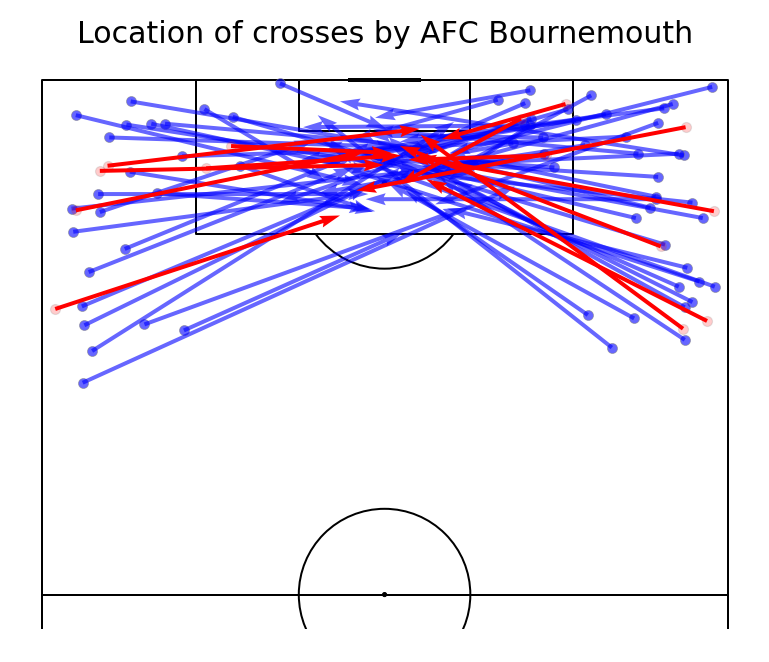

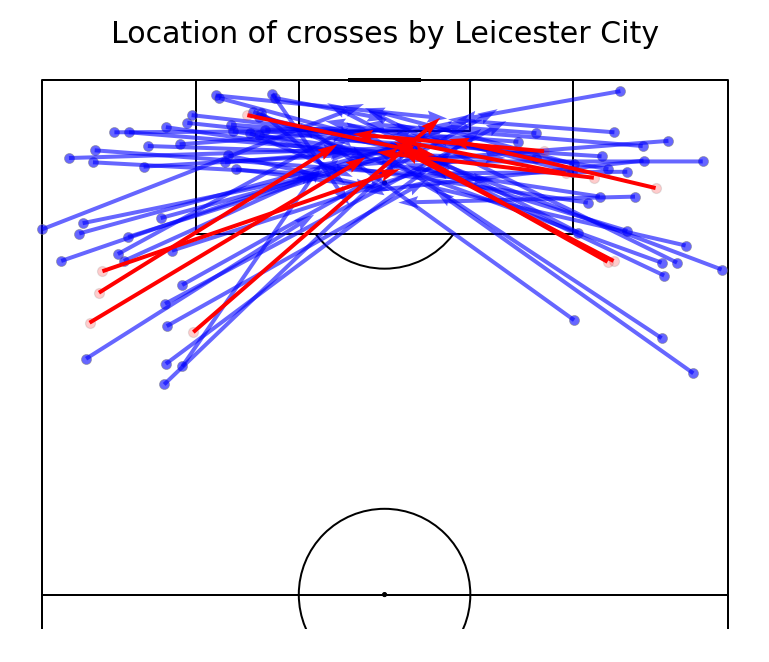

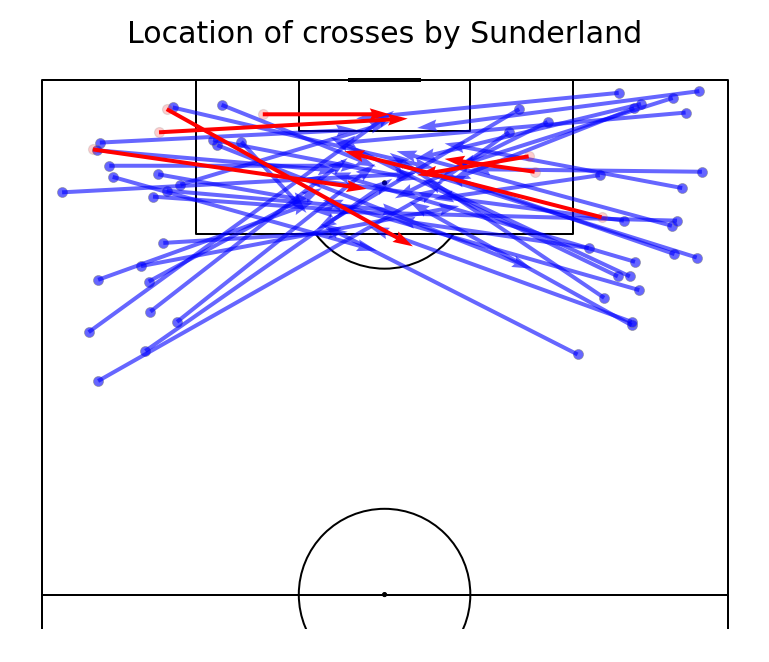

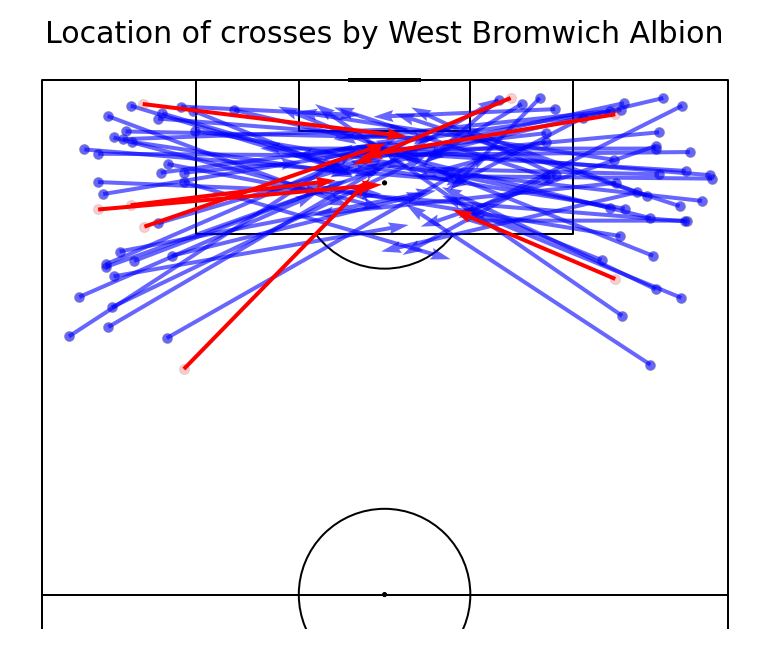

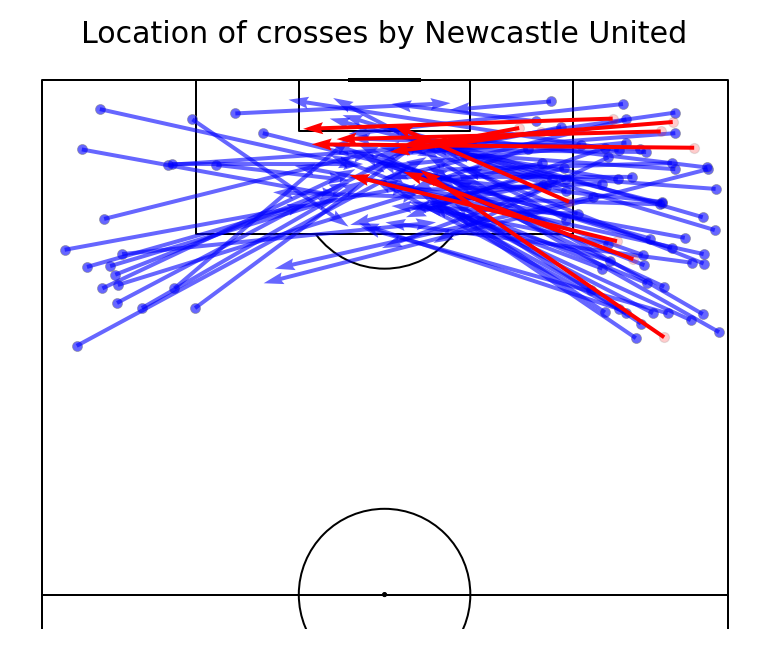

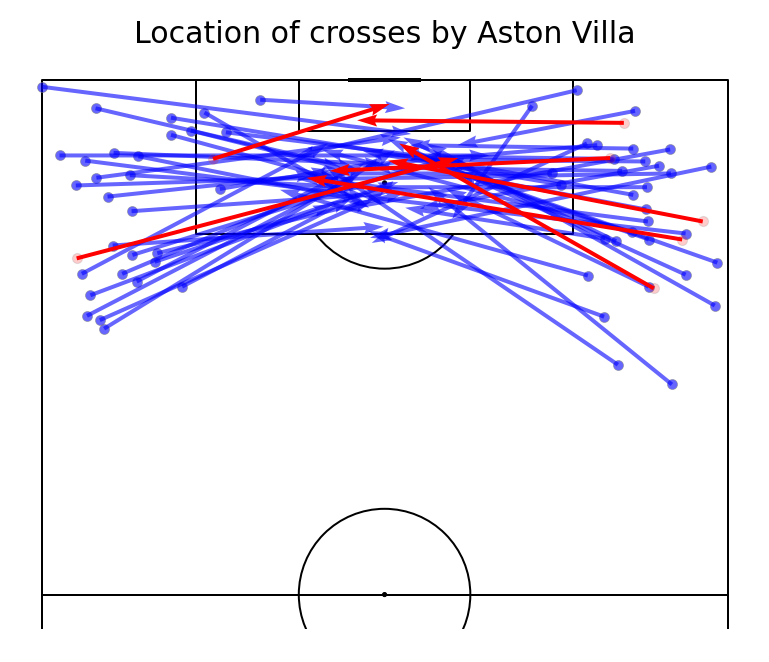

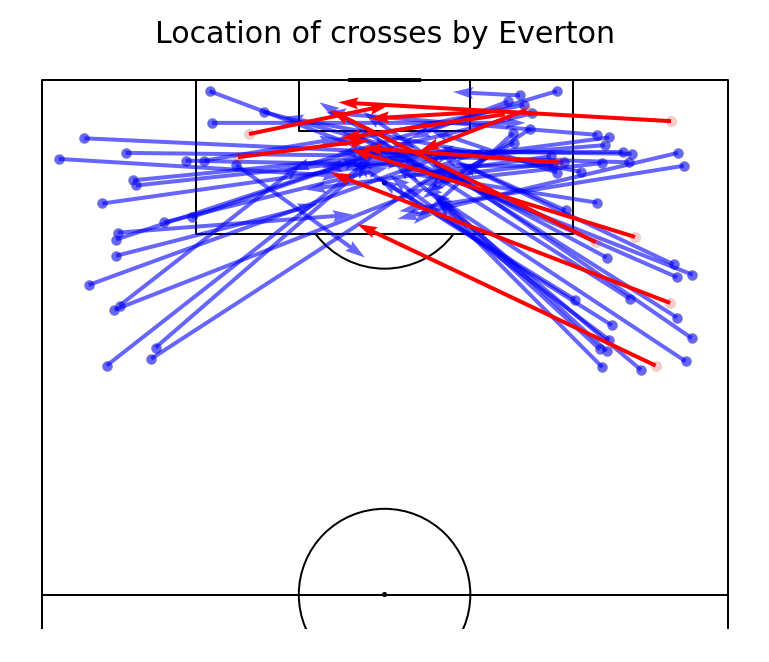

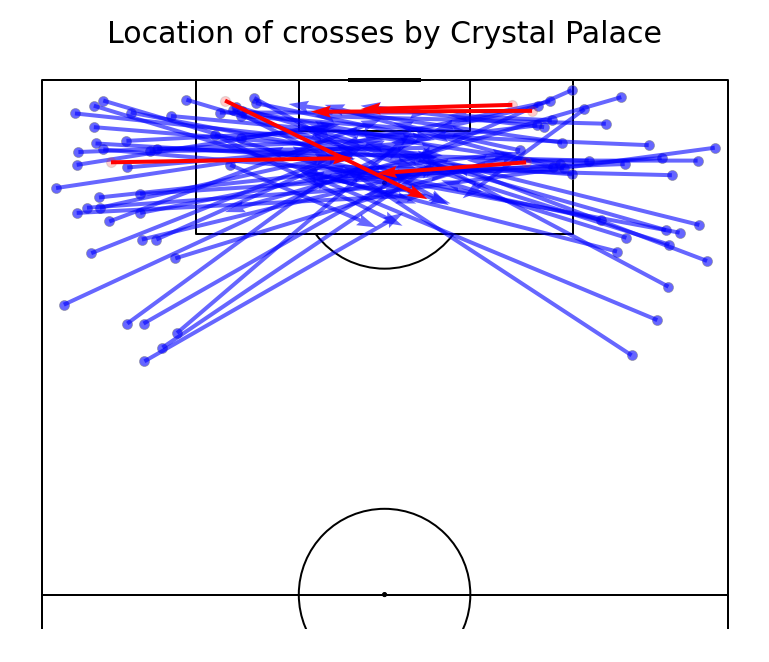

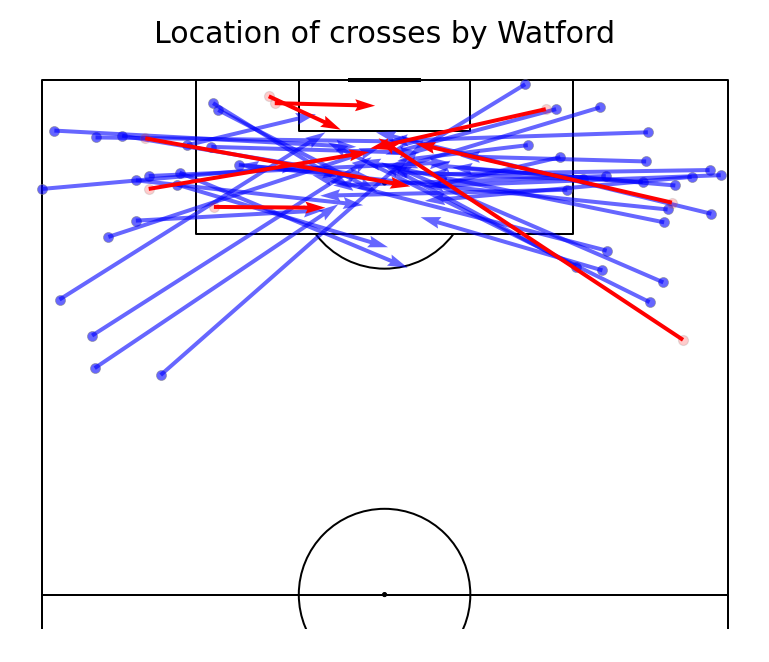

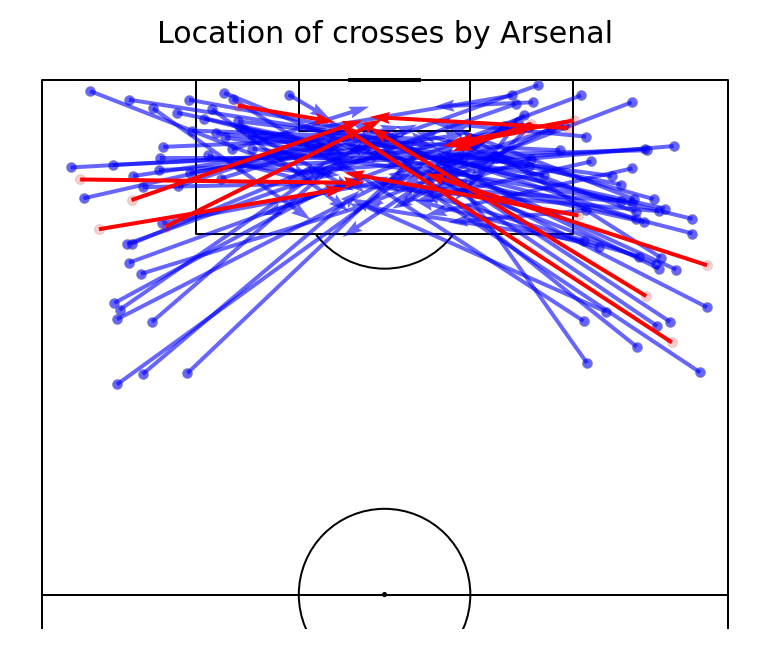

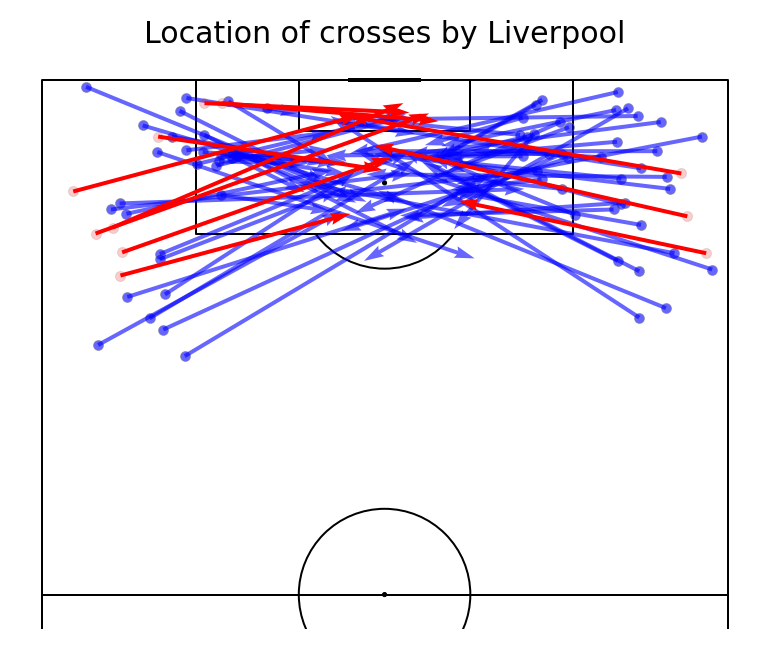

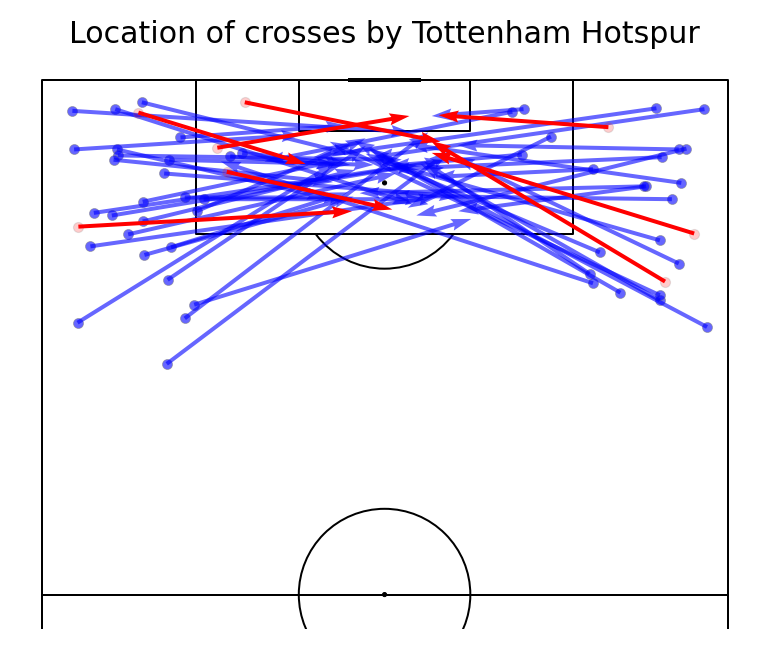

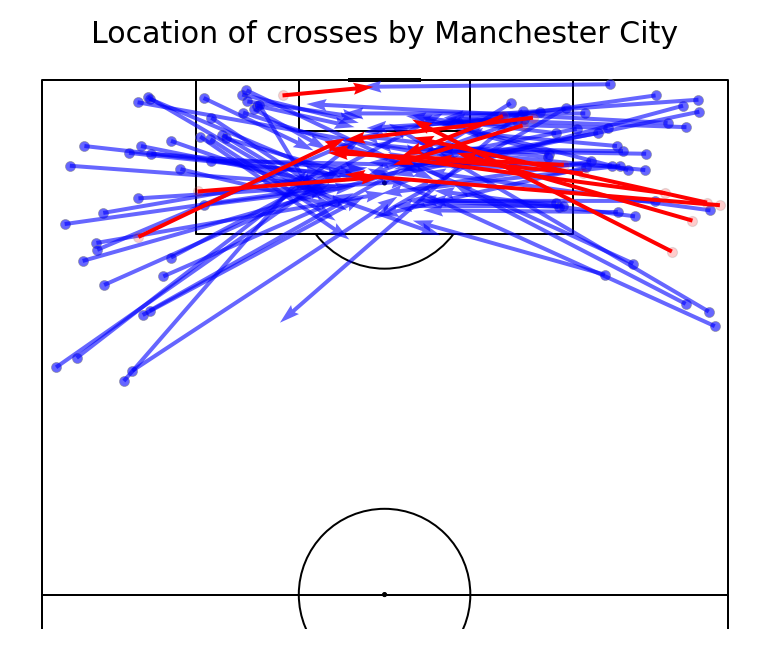

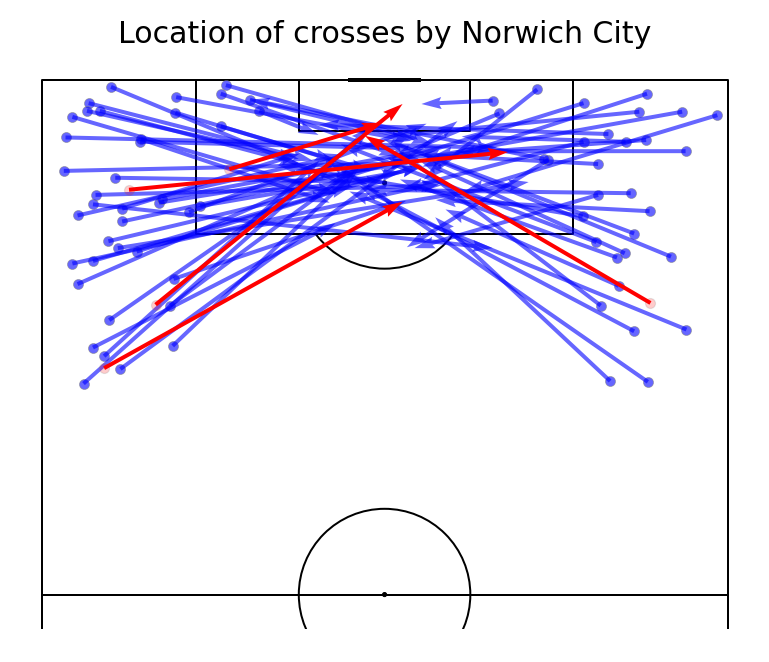

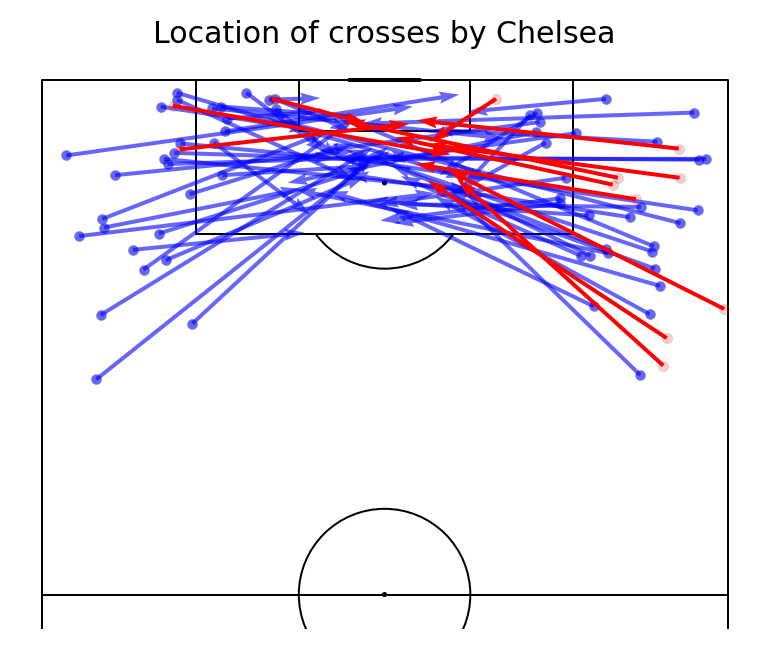

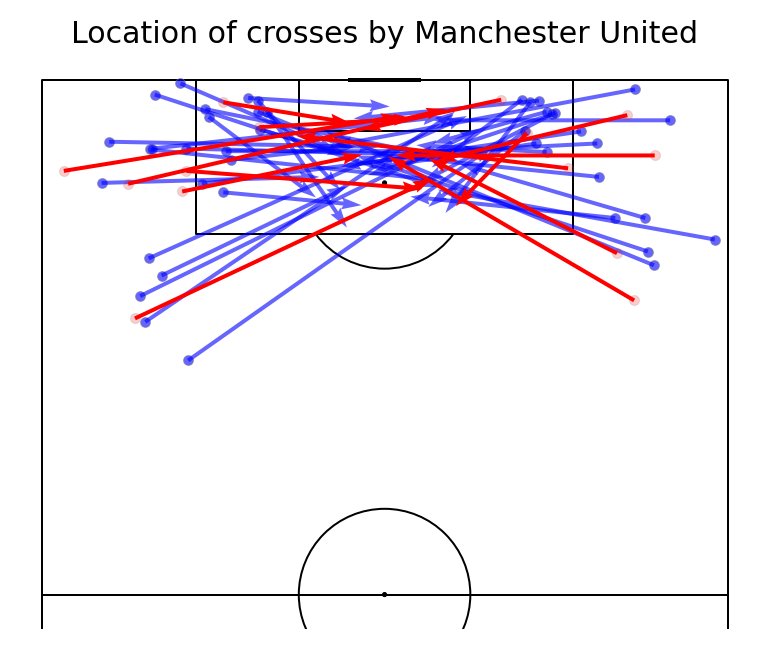

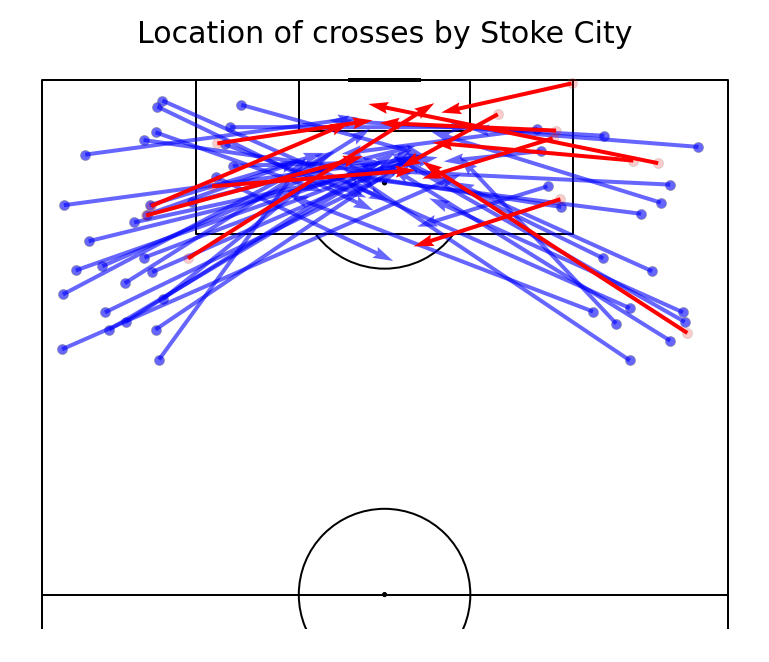

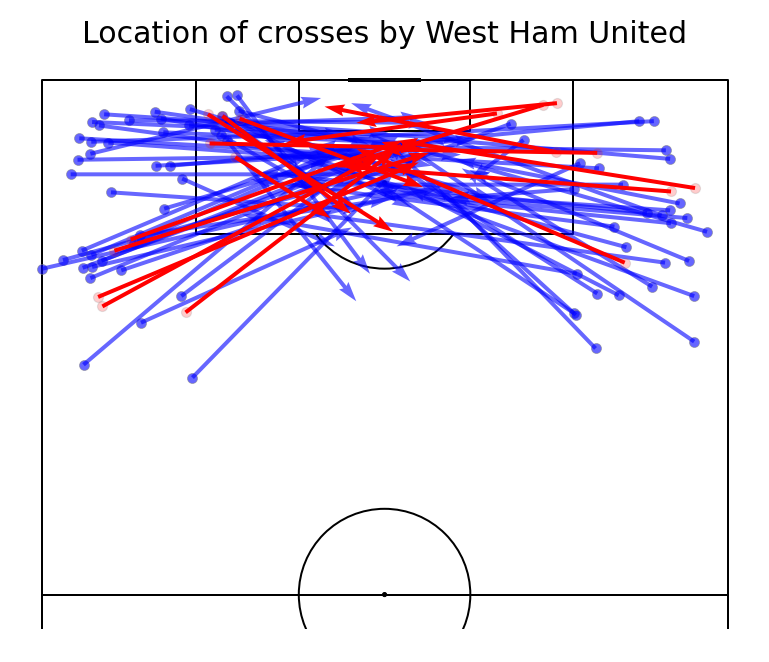

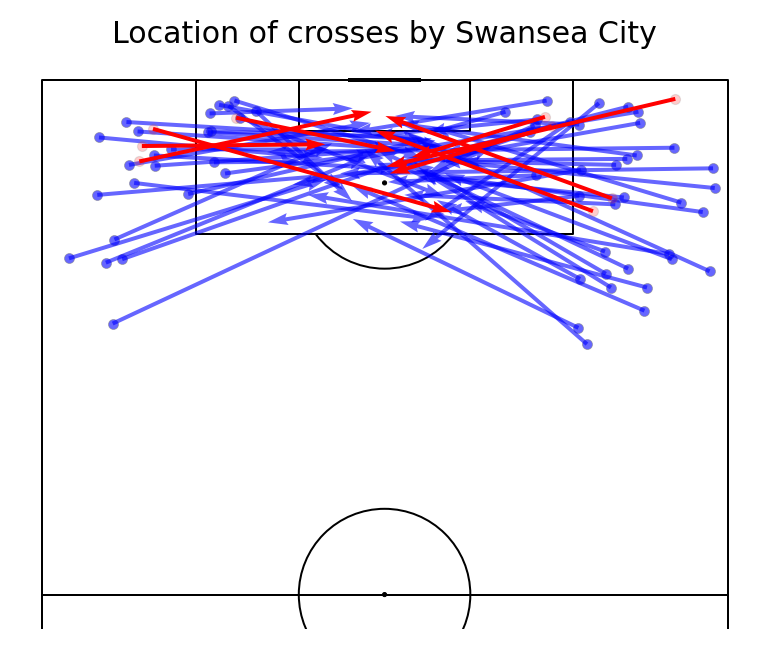

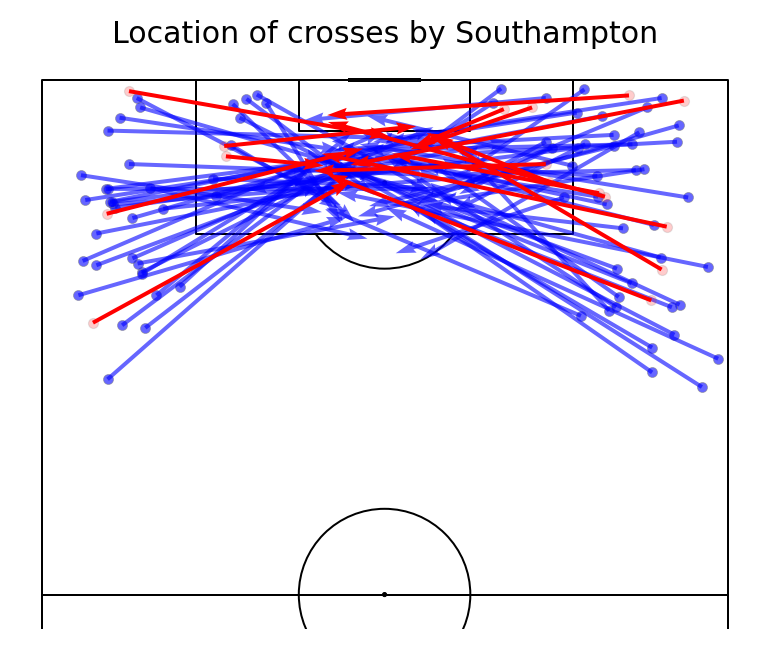

In [40]:
#deleting blank values
df_crosses_coordinates.dropna(inplace=True)
#coordinates should be floats for plotting
df_crosses_coordinates[['x','y','end_x','end_y']]=df_crosses_coordinates[['x','y','end_x','end_y']].astype(float)

#loop to create a separate dataframes for each team's crosses and goals scored from crosses
for team in df_crosses_coordinates['team_name'].unique():
    df_crosses_coordinates_team_goal = df_crosses_coordinates[(df_crosses_coordinates['team_name']==team) & 
                                                              (df_crosses_coordinates['cross_outcome']=='Goal')]
    df_crosses_coordinates_team_shot = df_crosses_coordinates[(df_crosses_coordinates['team_name']==team) & 
                                                              (df_crosses_coordinates['cross_outcome'].isin(['Off T','Blocked','Saved']))]
    
    #plot vertical pitch
    pitch = VerticalPitch(line_color='black',half=True)
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0, endnote_space=0)
    #scatter the location on the pitch for crosses (red if lead to goal, blue if lead to shot)
    pitch.scatter(df_crosses_coordinates_team_shot['x'], df_crosses_coordinates_team_shot['y'], s=100, color='blue', 
                      edgecolors='grey', linewidth=0.8, alpha=0.6, ax=ax["pitch"])
    #plot arrows
    pitch.arrows(df_crosses_coordinates_team_shot['x'], df_crosses_coordinates_team_shot['y'], 
                 df_crosses_coordinates_team_shot['end_x'], df_crosses_coordinates_team_shot['end_y'], 
                 color = "blue", ax=ax['pitch'], alpha=0.6)
    
    pitch.scatter(df_crosses_coordinates_team_goal['x'], df_crosses_coordinates_team_goal['y'], s=100, color='red', 
                    edgecolors='grey', linewidth=1.2, alpha=0.2, ax=ax["pitch"])
    #plot arrows
    pitch.arrows(df_crosses_coordinates_team_goal['x'], df_crosses_coordinates_team_goal['y'], 
                 df_crosses_coordinates_team_goal['end_x'], df_crosses_coordinates_team_goal['end_y'], color = "red", 
                 ax=ax['pitch'])

    #add title
    fig.suptitle('Location of crosses by ' + team, fontsize = 30)
    plt.show()

Interesting graphs for Newcastle United and Everton. Most of their crosses came from the right side and almost all of the
crosses that lead to goals came from the right side. Newcastle scored 10 goals from crosses, all of them from the right side. Everton scored 13 and only 2 after crosses from the left side. I will analyse Newcastle's crosses more thoroughly.

In [41]:
#check who made the crosses from the left for Newcastle
newcastle_crosses = df_crosses_coordinates[(df_crosses_coordinates['team_name']=='Newcastle United') & 
                                          (df_crosses_coordinates['y']<40)]
newcastle_crosses['player_name'].value_counts()

Moussa Sissoko             23
Ayoze Pérez Gutiérrez      17
Paul Dummett               13
Georginio Wijnaldum        10
Rolando Aarons              8
Jonjo Shelvey               8
Jack Colback                7
Florian Thauvin             6
Andros Townsend             5
Papiss Demba Cissé          5
Gabriel Antoine Obertan     4
Massadio Haïdara            4
Yoan Gouffran               2
Aleksandar Mitrović         2
Kevin Mbabu                 1
Seydou Doumbia              1
Vurnon Anita                1
Fabricio Coloccini          1
Name: player_name, dtype: int64

Next plot will show the average position on the pitch where Newcastle players received the ball. It will be interesting to see if it will explain why the number of crosses from the left side is significantly lower than from the right

In [42]:
#check the average position where Newcastle players received the ball
df_newcastle = df_all[(df_all['team_name']=='Newcastle United') & (df_all['pass_recipient_name'].notna())]
#type has to be changed to float to calculate mean
df_newcastle[['x','y','end_x','end_y']] = df_newcastle[['x','y','end_x','end_y']].astype(float)
#group by pass recipient
df_xy = df_newcastle.groupby(by='pass_recipient_name')

#calculate both average position and number of times player received the ball
df_xy_mean = pd.DataFrame(df_xy['end_x','end_y'].mean())
df_xy_count = pd.DataFrame(df_xy['end_x','end_y'].count())

df_xy_mean.reset_index(inplace=True)
df_xy_count.reset_index(inplace=True)

#merge both tables
df_xy = pd.merge(df_xy_mean,df_xy_count,on='pass_recipient_name')

#keep only players who recevied the ball more than 300 times
df_xy = df_xy[df_xy['end_x_y']>300]

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12224\130990137.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_newcastle[['x','y','end_x','end_y']] = df_newcastle[['x','y','end_x','end_y']].astype(float)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12224\130990137.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_xy_mean = pd.DataFrame(df_xy['end_x','end_y'].mean())
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12224\130990137.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_xy_count = pd.DataFrame(df_xy['end_x','end_y'].count())


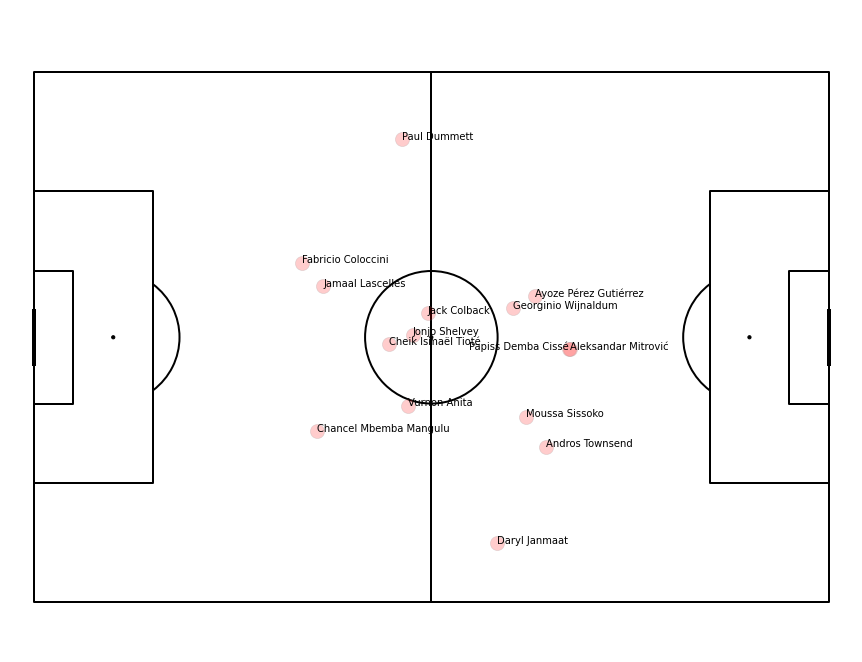

In [43]:
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                        endnote_height=0.04, title_space=0, endnote_space=0)
#scatter the average position where Newcastle players received the ball
pitch.scatter(df_xy['end_x_x'], df_xy['end_y_x'], s=200, color='red',edgecolors='grey', linewidth=0.8, 
              alpha=0.2, ax=ax["pitch"])

#loop to add annotations
#some player names were overlapping so their annotations will be manually moved by changing their text alignment
for index,row in df_xy.iterrows():
    if row['pass_recipient_name'] == 'Papiss Demba Cissé':
        pitch.annotate(row['pass_recipient_name'],(row['end_x_x'],row['end_y_x']),size='medium',color='black',
                   ha='right',ax=ax["pitch"])
    else:
        pitch.annotate(row['pass_recipient_name'],(row['end_x_x'],row['end_y_x']),size='medium',color='black',
                   ha='left',ax=ax["pitch"])

Newcastle team formation is definitely moved to the right side. Ayoze Perez and Georginio Wijnaldum keep to the center of the pitch, while Moussa Sissoko and Andros Townsend play more to the side. Also Daryl Janmaat on right back plays more offensively than Paul Dummett on the left side. The above plot helps explain why most crosses made by Newcastle came from the right side.

Next graph will show the most popular pairs of players crossing and receiving the ball. First I will create a new dataframe and new column with player pairs and check how many crosses and goals were among them in their entire season.

In [44]:
#goals scored from crosses among pairs of players

#from croos coordinates keep only player name, pass recipient name and cross outcome
df_crosses_players = df_crosses_coordinates[['player_name','pass_recipient_name','cross_outcome']]
#create new dataframe with the selected variables grouped by player name
df_crosses_pairs = df_crosses_players.groupby('player_name').value_counts().reset_index()
df_crosses_pairs.columns = ['player_name', 'pass_recipient_name','cross_outcome', 'count']
#create new dataframe with the selected variables grouped by player name and keep only goals scored
df_crosses_pairs_goals = df_crosses_pairs[df_crosses_pairs['cross_outcome']=='Goal'].sort_values(by='count',ascending=False)
#create new column based on player name and pass recipient name columns
df_crosses_pairs_goals['pair'] = df_crosses_pairs_goals['player_name']+" - "+df_crosses_pairs_goals['pass_recipient_name']
df_crosses_pairs_goals.drop(['player_name','pass_recipient_name','cross_outcome'],axis=1,inplace=True)
df_crosses_pairs_goals.rename({'count':'goals'},axis='columns',inplace=True)
df_crosses_pairs_goals

goals                                               pair
1199      4      Gerard Deulofeu Lázaro - Romelu Lukaku Menama
321       3                Anthony Martial - Wayne Mark Rooney
9         2                     Aaron Cresswell - Andy Carroll
1448      2           James Philip Milner - Divock Okoth Origi
833       2                Daryl Janmaat - Georginio Wijnaldum
...     ...                                                ...
1102      1  Faustino Marcos Alberto Rojo - Ander Herrera A...
1145      1      Gabriel Antoine Obertan - Georginio Wijnaldum
1177      1            Gaël Clichy - Kelechi Promise Iheanacho
1191      1          Georginio Wijnaldum - Aleksandar Mitrović
3271      1              Yann Gérard M''Vila - Steven Fletcher

[192 rows x 2 columns]

In [45]:
#crosses among pairs of players

#from croos coordinates keep only player name, pass recipient name
df_crosses_players_all = df_crosses_coordinates[['player_name','pass_recipient_name']]
#create new dataframe with the selected variables grouped by player name
df_crosses_pairs_all = df_crosses_players_all.groupby('player_name').value_counts().reset_index()
df_crosses_pairs_all.columns = ['player_name', 'pass_recipient_name','crosses']
#create new dataframe with the selected variables grouped by player name
df_crosses_pairs_shots = df_crosses_pairs_all.sort_values(by='crosses',ascending=False)
#create new column based on player name and pass recipient name columns
df_crosses_pairs_shots['pair'] = df_crosses_pairs_shots['player_name']+" - "+df_crosses_pairs_shots['pass_recipient_name']
df_crosses_pairs_shots.drop(['player_name','pass_recipient_name'],axis=1,inplace=True)
df_crosses_pairs_shots

crosses                                               pair
849        42      Gerard Deulofeu Lázaro - Romelu Lukaku Menama
678        37                       Dušan Tadić - Graziano Pellè
947        37             Ignacio Monreal Eraso - Olivier Giroud
1120       33  Jesús Navas González - Sergio Leonel Agüero de...
583        33                Daryl Janmaat - Aleksandar Mitrović
...       ...                                                ...
944         1                 Idrissa Gana Gueye - Jack Grealish
1529        1                        Mark Noble - Nikica Jelavić
1528        1                         Mark Noble - Dimitri Payet
1527        1                       Mark Noble - Aaron Cresswell
669         1                        Donald Love - Memphis Depay

[2369 rows x 2 columns]

In [46]:
#merge two dataframes on pair to have one table with both goals and crosses
df_crosses_pairs = pd.merge(df_crosses_pairs_shots,df_crosses_pairs_goals,on='pair')
df_crosses_pairs = df_crosses_pairs[['pair','crosses','goals']]
df_crosses_pairs

pair  crosses  goals
0        Gerard Deulofeu Lázaro - Romelu Lukaku Menama       42      4
1                         Dušan Tadić - Graziano Pellè       37      1
2               Ignacio Monreal Eraso - Olivier Giroud       37      2
3    Jesús Navas González - Sergio Leonel Agüero de...       33      1
4    Aleksandar Kolarov - Sergio Leonel Agüero del ...       32      1
..                                                 ...      ...    ...
187   Brendan Joel Zibusiso Galloway - Steven Naismith        1      1
188                          Nathan Dyer - Jamie Vardy        1      1
189                    Bamidele Alli - Kieran Trippier        1      1
190                          Ben Davies - Nacer Chadli        1      1
191                      Manuel Lanzini - Diafra Sakho        1      1

[192 rows x 3 columns]

On the below plot I will show the most populat pairs and how many crosses and goals were among them. The darker bar will show goals and the lighter one number of crosses.

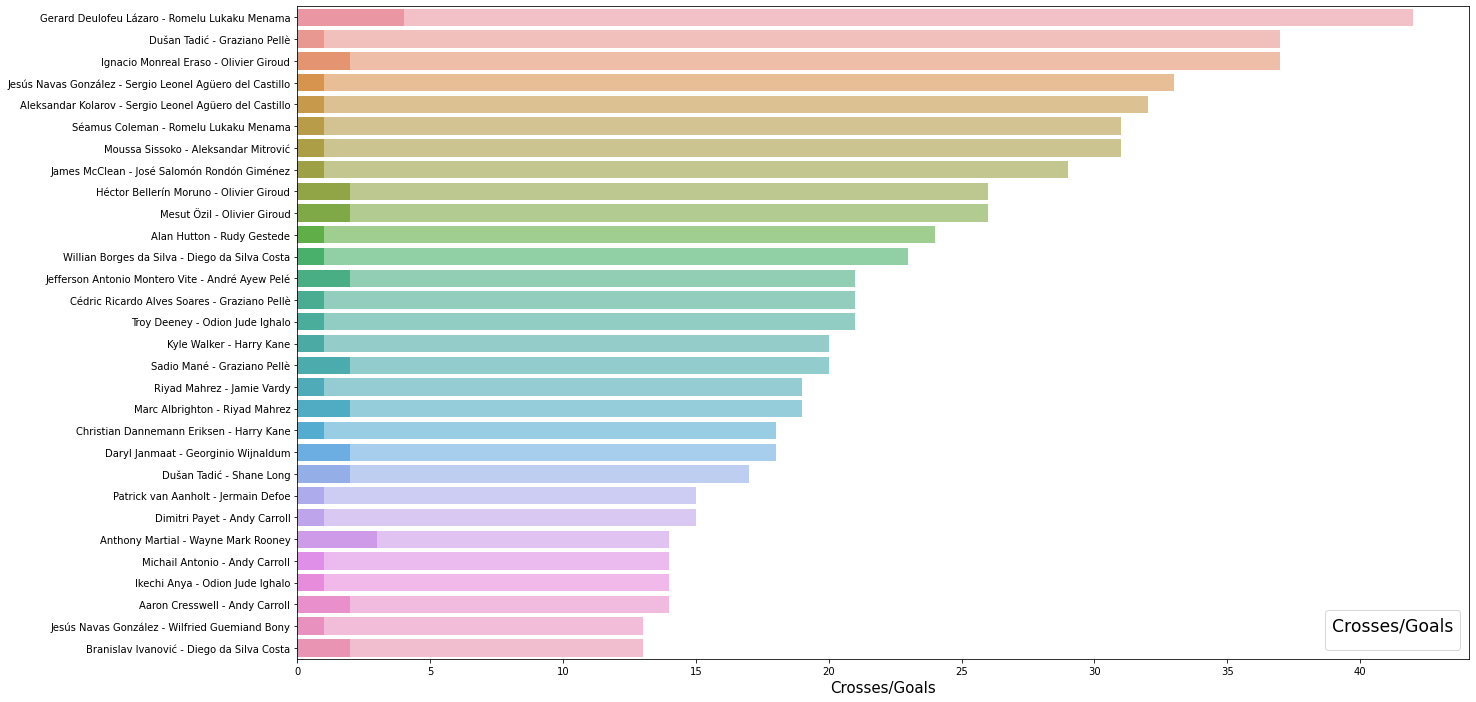

In [47]:
fig, ax = plt.subplots(figsize=(21, 12))

#show only top 30 pairs and calculate number of crosses for them
#change alpha to 0.6 to show goals on the same plot
p1 = sns.barplot(x='crosses',y='pair',alpha=0.6,data=df_crosses_pairs[:30])
#show only top 30 pairs and calculate number of goals for them
p2 = sns.barplot(x='goals',y='pair',data=df_crosses_pairs[:30])

plt.xlabel('Crosses/Goals', fontsize=15)
ax.set(ylabel=None)

legend = plt.legend(fontsize='xx-large',loc='lower right',handles=[p1,p2],
                    labels = ['Goals','Crosses'], 
                    labelcolor = ['orange','green'],
                    title='Crosses/Goals',title_fontsize='xx-large')

Graziano Pelle scored just 1 goal from 37 crosses made by his teammate Dusan Tadic. Meanwhile Pelle needed only 21 crosses from Sadio Mane to score 2 goals. Taking crosses directed to Graziano Pelle for a closer analysis, we will check if there is anything about these crosses that can explain such difference. First I will show crosses received by Graziano Pelle and made by five of his teammates.

In [48]:
df_crosses_coordinates.head()

x     y  end_x  end_y        team_name       player_name  \
232  115.5  68.0  108.7   48.1  AFC Bournemouth       Dan Gosling   
436   86.9  14.5  114.3   51.3   Leicester City   Marc Albrighton   
524  116.6  17.3  116.2   34.2  AFC Bournemouth   Charlie Daniels   
572   84.3  65.0  118.8   29.7  AFC Bournemouth     Simon Francis   
576  119.6  27.8  114.3   40.2  AFC Bournemouth  Junior Stanislas   

    pass_recipient_name pass_length pass_angle pass_height_name cross_outcome  
232         Joshua King   21.029741  -1.900065      Ground Pass       No shot  
436        Riyad Mahrez    45.88028   0.930783        High Pass         Off T  
524         Joshua King   16.904734   1.594461      Ground Pass       No shot  
572    Junior Stanislas   49.359295  -0.796859        High Pass       No shot  
576         Joshua King   13.485177   1.974714        High Pass         Off T

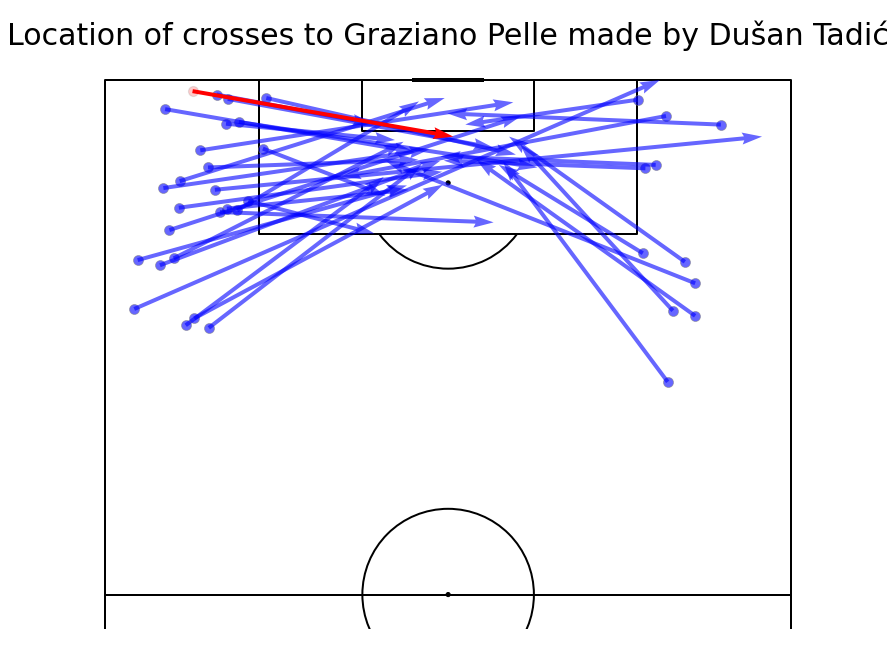

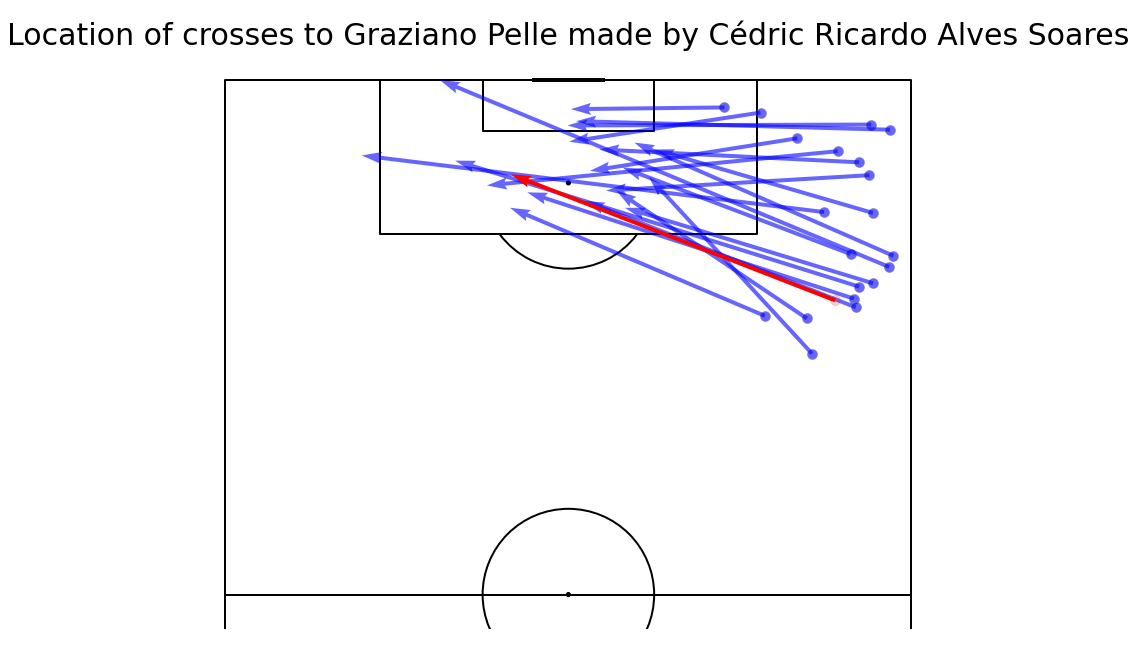

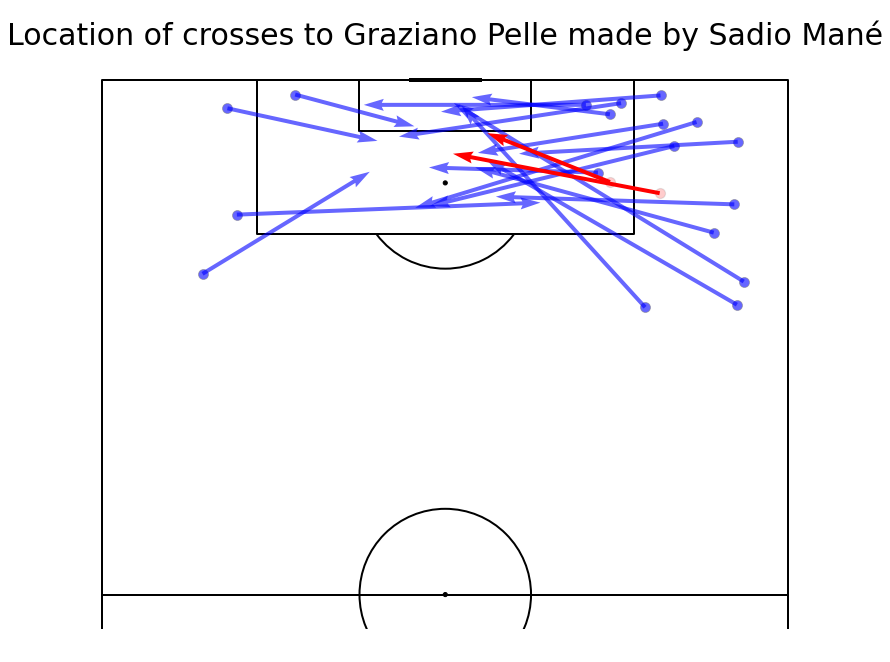

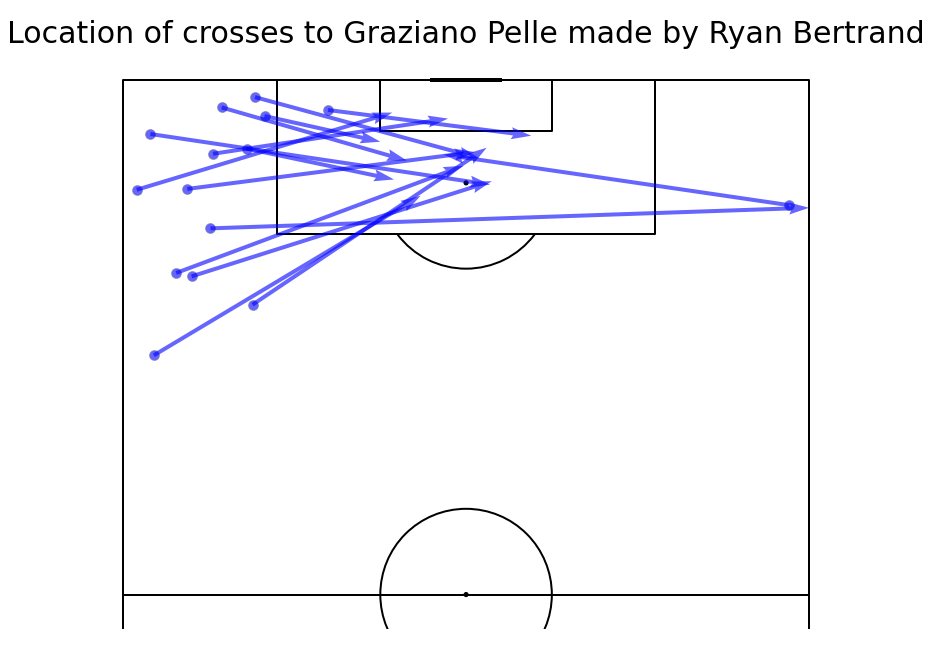

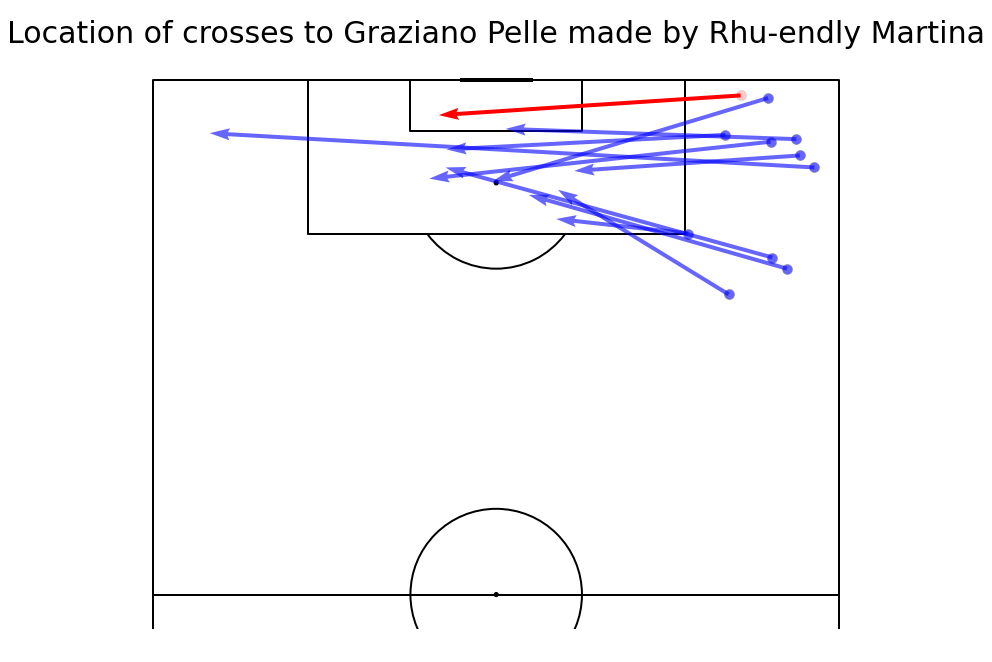

In [49]:
df_crosses_coordinates.dropna(inplace=True)
df_crosses_coordinates[['x','y','end_x','end_y']]=df_crosses_coordinates[['x','y','end_x','end_y']].astype(float)

#keep only crosses received by Pelle
df_crosses_pelle = df_crosses_coordinates[(df_crosses_coordinates['pass_recipient_name']=='Graziano Pellè')]
players_crosses = df_crosses_pelle['player_name'].value_counts().reset_index()

#get 5 players who made the most crosses received by Pelle
top5_players_crosses = list(players_crosses[:5]['index'].unique())

#for each player in this list show graph showing crosses and goals from crosses
for player in top5_players_crosses:
    
    #for each player create a new dataframe
    df_crosses_player_to_pelle = df_crosses_pelle[df_crosses_pelle['player_name']==player]
    #create new dataframe with goals only
    goal_to_plot = df_crosses_player_to_pelle[df_crosses_player_to_pelle['cross_outcome']=='Goal']
    #create new dataframe with crosses that did not end with goals
    no_goal_to_plot = df_crosses_player_to_pelle[df_crosses_player_to_pelle['cross_outcome']!='Goal']
    
    
    #plot vertical pitch
    pitch = VerticalPitch(line_color='black',half=True)
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                             endnote_height=0.04, title_space=0, endnote_space=0)
    #scatter the location on the pitch for crosses (red if lead to goal, blue if lead to shot)
    pitch.scatter(no_goal_to_plot['x'], no_goal_to_plot['y'], s=100, color='blue', 
                        edgecolors='grey', linewidth=0.8, alpha=0.6, ax=ax["pitch"])
    #plot arrows
    pitch.arrows(no_goal_to_plot['x'], no_goal_to_plot['y'], 
                    no_goal_to_plot['end_x'], no_goal_to_plot['end_y'], 
                    color = "blue", ax=ax['pitch'], alpha=0.6)

    pitch.scatter(goal_to_plot['x'], goal_to_plot['y'], s=100, color='red', 
                    edgecolors='grey', linewidth=1.2, alpha=0.2, ax=ax["pitch"])
    #plot arrows
    pitch.arrows(goal_to_plot['x'], goal_to_plot['y'], 
                    goal_to_plot['end_x'], goal_to_plot['end_y'], color = "red", 
                    ax=ax['pitch'])

    #add title
    fig.suptitle('Location of crosses to Graziano Pelle made by ' + player, fontsize = 30)
    plt.show()

It is difficult to come to any conclusions based on the crosses coordinates only. In the next step I will analyse the pass lenght and pass height.

<AxesSubplot:xlabel='player_name', ylabel='pass_length'>

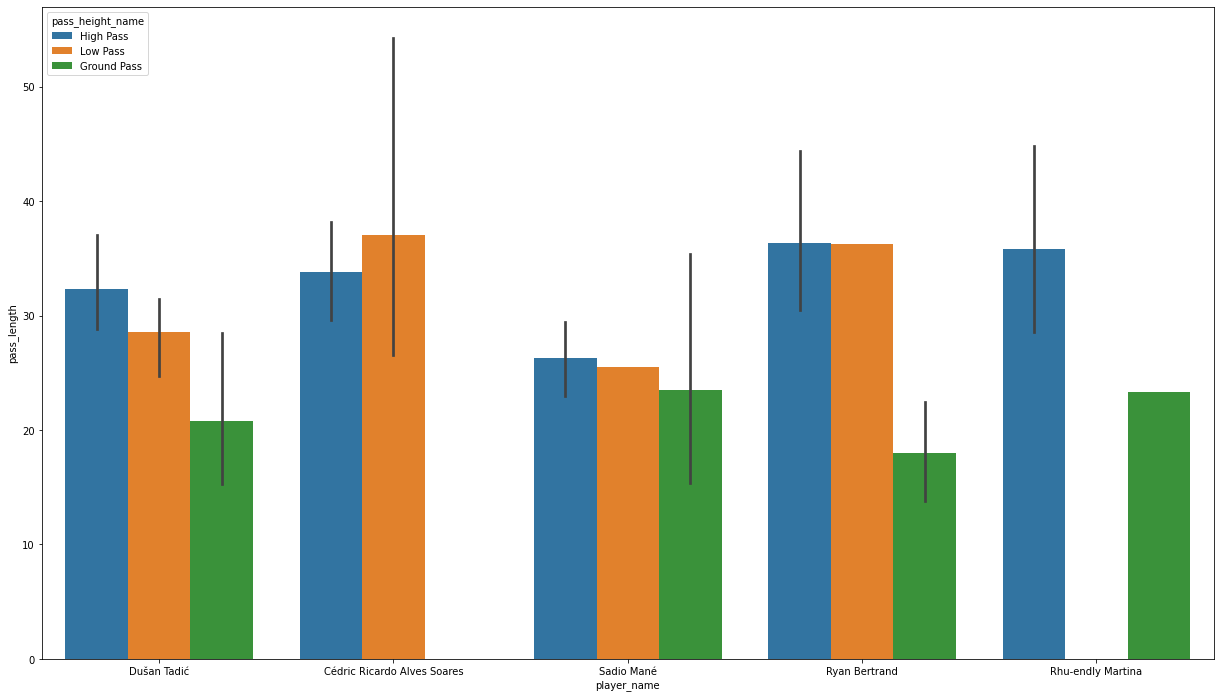

In [50]:
#compare pass height among 5 players making a cross to Graziano Pelle
df_top5_players_crosses = df_crosses_pelle[df_crosses_pelle['player_name'].isin(top5_players_crosses)]

fig, ax = plt.subplots(figsize=(21, 12))
sns.barplot(x='player_name',y='pass_length',hue='pass_height_name',data=df_top5_players_crosses)

<AxesSubplot:xlabel='player_name', ylabel='pass_length'>

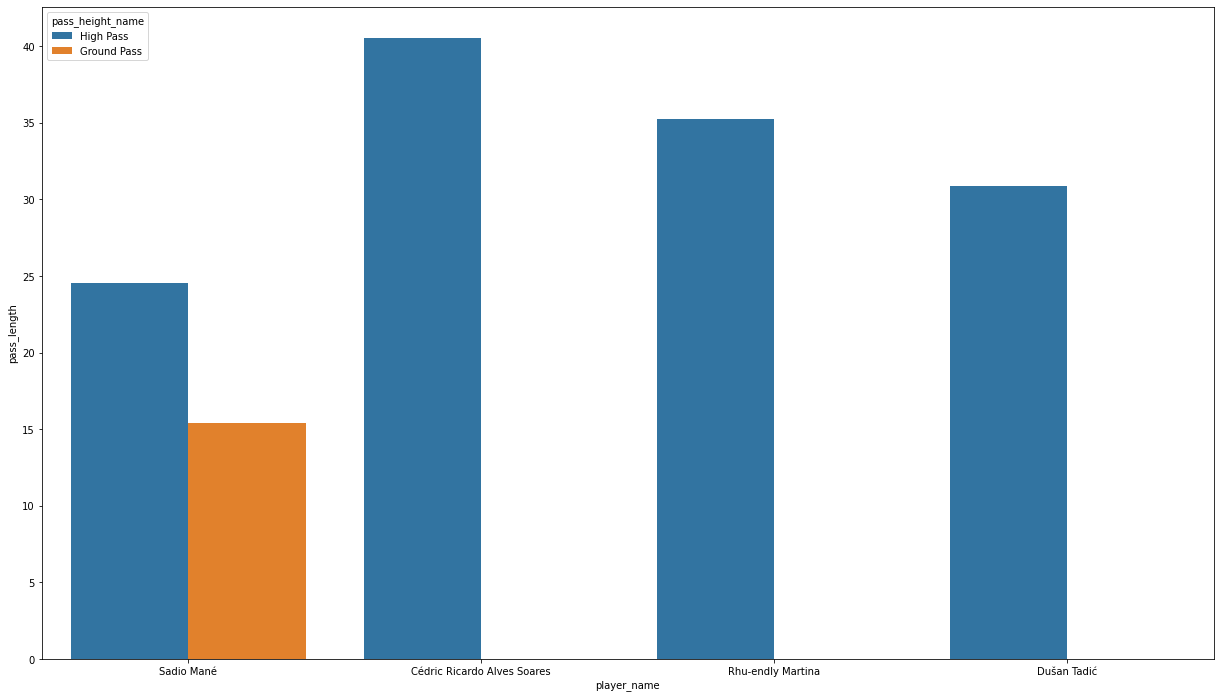

In [51]:
#compare pass length among 5 players making a cross to Graziano Pelle
df_top5_players_crosses = df_crosses_pelle[df_crosses_pelle['player_name'].isin(top5_players_crosses)]

fig, ax = plt.subplots(figsize=(21, 12))
sns.barplot(x='player_name',y='pass_length',hue='pass_height_name',
            data=df_top5_players_crosses[df_top5_players_crosses['cross_outcome']=='Goal'])

Sadio Mane's crosses are shorter than other teammates (most probably because he is a striker too and plays much closer to Graziano Pelle). His two crosses that resulted in goals were shorter and one of them was a ground pass too.

# PRE-PROCESSING

In the next step I will prepare data for model and prediction. I will try to check if models are able to predict the outcome of the cross based on the attributes available in the event data.

In [52]:
df_all.columns

Index(['index', 'period', 'minute', 'second', 'possession', 'duration',
       'match_id', 'type_id', 'type_name', 'possession_team_id',
       'possession_team_name', 'play_pattern_name', 'team_name', 'player_name',
       'position_name', 'pass_recipient_name', 'pass_length', 'pass_angle',
       'pass_height_name', 'end_x', 'end_y', 'body_part_name', 'sub_type_name',
       'x', 'y', 'outcome_name', 'under_pressure', 'pass_cross', 'pass_switch',
       'counterpress', 'ball_recovery_recovery_failure', 'shot_statsbomb_xg',
       'end_z', 'shot_key_pass_id', 'technique_name',
       'goalkeeper_position_name', 'aerial_won', 'foul_won_defensive',
       'pass_shot_assist', 'level_0', 'time', 'leads_to_shot',
       'cross_outcome'],
      dtype='object')

In [53]:
#create na new dataframe with less columns and keep only crosses
df_model = df_all[['play_pattern_name', 'team_name', 'player_name',
       'position_name', 'pass_recipient_name', 'pass_length', 'pass_angle',
       'pass_height_name', 'end_x', 'end_y', 'body_part_name', 'sub_type_name',
       'x', 'y', 'outcome_name', 'under_pressure', 'pass_cross', 'pass_switch',
       'time', 'cross_outcome']]
df_model = df_model[df_model['pass_cross']==True]
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9545 entries, 232 to 1313478
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   play_pattern_name    9545 non-null   object 
 1   team_name            9545 non-null   object 
 2   player_name          9545 non-null   object 
 3   position_name        9545 non-null   object 
 4   pass_recipient_name  6871 non-null   object 
 5   pass_length          9545 non-null   object 
 6   pass_angle           9545 non-null   object 
 7   pass_height_name     9545 non-null   object 
 8   end_x                9545 non-null   object 
 9   end_y                9545 non-null   object 
 10  body_part_name       9434 non-null   object 
 11  sub_type_name        998 non-null    object 
 12  x                    9545 non-null   object 
 13  y                    9545 non-null   object 
 14  outcome_name         6921 non-null   object 
 15  under_pressure       1086 non-nul

## Getting rid of null values

In [54]:
df_model['pass_recipient_name'].value_counts()

Romelu Lukaku Menama                 178
Sergio Leonel Agüero del Castillo    151
Olivier Giroud                       148
Graziano Pellè                       135
Odion Jude Ighalo                    129
                                    ... 
Adam Smith                             1
Sullay Kaikai                          1
Osazemwinde Peter Odemwingie           1
Vito Mannone                           1
Jon Flanagan                           1
Name: pass_recipient_name, Length: 407, dtype: int64

Pass recipient name has 407 different values so we should drop it

In [55]:
df_model.drop('pass_recipient_name',axis=1,inplace=True)

In [56]:
df_model['body_part_name'].value_counts()

Right Foot    5517
Left Foot     3833
Head            80
Other            2
Drop Kick        1
No Touch         1
Name: body_part_name, dtype: int64

Body part name has two rare values and blanks. They will all be classified as 'other'.

In [57]:
df_model['body_part_name'].replace(['Drop Kick','No Touch'],'Other',inplace=True)
df_model['body_part_name'].fillna('Other',inplace=True)
df_model['body_part_name'].value_counts()

Right Foot    5517
Left Foot     3833
Other          115
Head            80
Name: body_part_name, dtype: int64

In [58]:
df_model['sub_type_name'].value_counts()

Free Kick    763
Recovery     173
Throw-in      62
Name: sub_type_name, dtype: int64

Most values in sub type name are blank values. We can call them 'open play' and keep the rest unchanged.

In [59]:
df_model['sub_type_name'].fillna('Open play',inplace=True)
df_model['sub_type_name'].value_counts()

Open play    8547
Free Kick     763
Recovery      173
Throw-in       62
Name: sub_type_name, dtype: int64

In [60]:
df_model['outcome_name'].value_counts()

Incomplete          6077
Out                  692
Pass Offside          77
Unknown               64
Injury Clearance      11
Name: outcome_name, dtype: int64

Outcome_name adds no value about the cross characteristics but rather gives a hint about its outcome, which I will be trying to determine using my model. Therefore outcome_name should be dropped

In [61]:
df_model.drop('outcome_name',axis=1,inplace=True)

In [62]:
df_model['under_pressure'].value_counts()

1.0    1086
Name: under_pressure, dtype: int64

Under pressure has blank values that will be replaced with 0 (False). The same will be applied to pass switch.

In [63]:
df_model['under_pressure'].fillna(0,inplace=True)
df_model['under_pressure'].value_counts()

0.0    8459
1.0    1086
Name: under_pressure, dtype: int64

In [64]:
df_model['pass_switch'].value_counts()

True    1543
Name: pass_switch, dtype: int64

In [65]:
df_model['pass_switch'].replace(True,1,inplace=True)
df_model['pass_switch'].fillna(0,inplace=True)
df_model['pass_switch'].value_counts()

0.0    8002
1.0    1543
Name: pass_switch, dtype: int64

In [66]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9545 entries, 232 to 1313478
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   play_pattern_name  9545 non-null   object 
 1   team_name          9545 non-null   object 
 2   player_name        9545 non-null   object 
 3   position_name      9545 non-null   object 
 4   pass_length        9545 non-null   object 
 5   pass_angle         9545 non-null   object 
 6   pass_height_name   9545 non-null   object 
 7   end_x              9545 non-null   object 
 8   end_y              9545 non-null   object 
 9   body_part_name     9545 non-null   object 
 10  sub_type_name      9545 non-null   object 
 11  x                  9545 non-null   object 
 12  y                  9545 non-null   object 
 13  under_pressure     9545 non-null   float64
 14  pass_cross         9545 non-null   object 
 15  pass_switch        9545 non-null   float64
 16  time               

No more blanks. I will now move on to columns that have no blanks but they have too many different values.

## Getting rid of too many different values

In [67]:
df_model['play_pattern_name'].value_counts()

Regular Play      3486
From Throw In     2474
From Free Kick    1893
From Corner        886
From Goal Kick     459
From Kick Off      151
From Keeper        130
From Counter        58
Other                8
Name: play_pattern_name, dtype: int64

In [68]:
df_model[df_model['play_pattern_name']=='From Free Kick']['cross_outcome'].value_counts()

No shot    1560
Off T       166
Blocked      61
Saved        60
Goal         46
Name: cross_outcome, dtype: int64

In [69]:
df_model[df_model['play_pattern_name']=='From Corner']['cross_outcome'].value_counts()

No shot    697
Off T       84
Blocked     47
Saved       34
Goal        24
Name: cross_outcome, dtype: int64

Corner and Free Kick are similar in terms of play pattern. The outcome of the crosses made after corners look similar as well. Based on this observation, we can join them in one group. Less frequent patterns will all be trated as 'Other'.

In [70]:
df_model['play_pattern_name'].replace(['From Free Kick','From Corner'],'From Free Kick/Corner',inplace=True)
df_model['play_pattern_name'].replace(['From Goal Kick','From Kick Off','From Keeper','From Counter'],'Other',inplace=True)
df_model['play_pattern_name'].value_counts()

Regular Play             3486
From Free Kick/Corner    2779
From Throw In            2474
Other                     806
Name: play_pattern_name, dtype: int64

team_name and player_name have too many different values. Both will be dropped.

In [71]:
df_model.drop(['team_name','player_name'],axis=1,inplace=True)

In [72]:
df_model['position_name'].value_counts()

Left Back                    1644
Right Back                   1505
Right Wing                   1100
Left Wing                     986
Center Attacking Midfield     725
Left Midfield                 679
Right Midfield                662
Center Forward                450
Right Center Midfield         304
Left Center Midfield          249
Right Defensive Midfield      236
Left Defensive Midfield       210
Left Center Forward           173
Right Center Forward          155
Left Wing Back                107
Right Wing Back               101
Right Center Back              76
Center Defensive Midfield      76
Left Center Back               72
Right Attacking Midfield       21
Left Attacking Midfield         9
Center Back                     5
Name: position_name, dtype: int64

position_name variable should be useful for my model, but it has too many different values. Main groups should be Forwards, Wingers, Full Backs, Offensive Midfielders and Defenders. Differentiation on left and right is not necessary either because x and y variables hold the information from which place on the pitch the cross was made.

In [73]:
df_model['position_name'].replace(['Left Back','Right Back','Left Wing Back','Right Wing Back'],'Full Back',inplace=True)
df_model['position_name'].replace(['Right Wing','Left Wing','Left Midfield','Right Midfield'],'Winger',inplace=True)
df_model['position_name'].replace(['Center Forward','Left Center Forward','Right Center Forward'],'Forward',inplace=True)
df_model['position_name'].replace(['Center Attacking Midfield','Right Center Midfield','Left Center Midfield',
                                  'Right Attacking Midfield','Left Attacking Midfield'],'Offensive Midfielder',inplace=True)
df_model['position_name'].replace(['Right Defensive Midfield','Left Defensive Midfield','Right Center Back',
                                  'Center Defensive Midfield','Left Center Back','Center Back'],'Defender',inplace=True)
df_model['position_name'].value_counts()

Winger                  3427
Full Back               3357
Offensive Midfielder    1308
Forward                  778
Defender                 675
Name: position_name, dtype: int64

In [74]:
df_model['pass_height_name'].value_counts()

High Pass      6735
Ground Pass    1481
Low Pass       1329
Name: pass_height_name, dtype: int64

In [75]:
df_model['pass_cross'].value_counts()

True    9545
Name: pass_cross, dtype: int64

In [76]:
df_model.drop('pass_cross',axis=1,inplace=True)

Pass hight name can remain unchanged. Pass_cross has the same value for every row so it will be dropped.

## Updating data types

Ultimately all data should be numerical so those columns that can be a float should be updated.

In [77]:
df_model['pass_length'].value_counts()

25.204960    5
31.016125    5
27.636570    4
21.523243    4
21.708294    4
            ..
12.022063    1
25.262224    1
33.271008    1
12.379418    1
21.112318    1
Name: pass_length, Length: 8384, dtype: int64

In [78]:
df_model['pass_angle'].value_counts()

-1.570796    73
 1.570796    65
 1.735945     8
-1.892547     8
 1.405648     5
             ..
 1.276971     1
 1.277971     1
-1.605265     1
-1.043992     1
 1.039312     1
Name: pass_angle, Length: 8763, dtype: int64

In [79]:
df_model[['x','y','end_x','end_y','pass_length','pass_angle']]=df_model[['x','y','end_x','end_y','pass_length',
                                                                         'pass_angle']].astype(float)

In [80]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9545 entries, 232 to 1313478
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   play_pattern_name  9545 non-null   object 
 1   position_name      9545 non-null   object 
 2   pass_length        9545 non-null   float64
 3   pass_angle         9545 non-null   float64
 4   pass_height_name   9545 non-null   object 
 5   end_x              9545 non-null   float64
 6   end_y              9545 non-null   float64
 7   body_part_name     9545 non-null   object 
 8   sub_type_name      9545 non-null   object 
 9   x                  9545 non-null   float64
 10  y                  9545 non-null   float64
 11  under_pressure     9545 non-null   float64
 12  pass_switch        9545 non-null   float64
 13  time               9545 non-null   float64
 14  cross_outcome      9545 non-null   object 
dtypes: float64(9), object(6)
memory usage: 1.2+ MB


cross_outcome categories will be replaced with numerical values to create classes for my model. Other columns with Dtype object will be formatted using one hot encoding.

In [81]:
#get one hot encoding of columns with dtype=object
one_hot = pd.get_dummies(df_model[['play_pattern_name','position_name','pass_height_name','body_part_name',
                                   'sub_type_name']])
#drop encoded columns
df_model.drop(['play_pattern_name','position_name','pass_height_name','body_part_name',
               'sub_type_name'],axis = 1,inplace=True)
#join the encoded dataframe
df_model = df_model.join(one_hot)

In [82]:
df_model.head()

pass_length  pass_angle  end_x  end_y      x     y  under_pressure  \
232    21.029741   -1.900065  108.7   48.1  115.5  68.0             1.0   
436    45.880280    0.930783  114.3   51.3   86.9  14.5             0.0   
524    16.904734    1.594461  116.2   34.2  116.6  17.3             0.0   
572    49.359295   -0.796859  118.8   29.7   84.3  65.0             0.0   
576    13.485177    1.974714  114.3   40.2  119.6  27.8             0.0   

     pass_switch   time cross_outcome  ...  pass_height_name_High Pass  \
232          0.0  288.0       No shot  ...                           0   
436          0.0  557.0         Off T  ...                           1   
524          0.0  717.0       No shot  ...                           0   
572          0.0  787.0       No shot  ...                           1   
576          0.0  790.0         Off T  ...                           1   

     pass_height_name_Low Pass  body_part_name_Head  body_part_name_Left Foot  \
232                          0                    0                         0   
436                          0                    0                         0   
524                          0                    0                         1   
572                          0                    0                         0   
576                          0                    0                         1   

     body_part_name_Other  body_part_name_Right Foot  sub_type_name_Free Kick  \
232                     0                          1                        0   
436                     0                          1                        0   
524                     0                          0                        0   
572                     0                          1                        0   
576                     0                          0                        0   

     sub_type_name_Open play  sub_type_name_Recovery  sub_type_name_Throw-in  
232                        1                       0                       0  
436                        1                       0                       0  
524                        1                       0                       0  
572                        1                       0                       0  
576                        1                       0                       0  

[5 rows x 30 columns]

In [83]:
#create mapping for cross_outcome
class_mapping = {'No shot':0,'Off T':1,'Blocked':2,'Saved':3,'Goal':4}
df_model['cross_outcome'] = df_model['cross_outcome'].map(class_mapping)
df_model

pass_length  pass_angle  end_x  end_y      x     y  under_pressure  \
232        21.029741   -1.900065  108.7   48.1  115.5  68.0             1.0   
436        45.880280    0.930783  114.3   51.3   86.9  14.5             0.0   
524        16.904734    1.594461  116.2   34.2  116.6  17.3             0.0   
572        49.359295   -0.796859  118.8   29.7   84.3  65.0             0.0   
576        13.485177    1.974714  114.3   40.2  119.6  27.8             0.0   
...              ...         ...    ...    ...    ...   ...             ...   
1313104    24.120737   -0.759011  105.5   47.6   88.0  64.2             0.0   
1313274    19.553260   -1.075123  103.3   44.9   94.0  62.1             0.0   
1313313    29.328655   -1.280319  112.9   46.2  104.5  74.3             0.0   
1313401    12.778107    2.267539  105.6   30.8  113.8  21.0             0.0   
1313478    21.112318    1.039312  105.9   32.4   95.2  14.2             0.0   

         pass_switch    time  cross_outcome  ...  pass_height_name_High Pass  \
232              0.0   288.0              0  ...                           0   
436              0.0   557.0              1  ...                           1   
524              0.0   717.0              0  ...                           0   
572              0.0   787.0              0  ...                           1   
576              0.0   790.0              1  ...                           1   
...              ...     ...            ...  ...                         ...   
1313104          0.0  4440.0              0  ...                           1   
1313274          0.0  4788.0              0  ...                           0   
1313313          0.0  4839.0              0  ...                           1   
1313401          0.0  4964.0              0  ...                           0   
1313478          0.0  5130.0              0  ...                           0   

         pass_height_name_Low Pass  body_part_name_Head  \
232                              0                    0   
436                              0                    0   
524                              0                    0   
572                              0                    0   
576                              0                    0   
...                            ...                  ...   
1313104                          0                    0   
1313274                          1                    0   
1313313                          0                    0   
1313401                          0                    0   
1313478                          0                    0   

         body_part_name_Left Foot  body_part_name_Other  \
232                             0                     0   
436                             0                     0   
524                             1                     0   
572                             0                     0   
576                             1                     0   
...                           ...                   ...   
1313104                         0                     0   
1313274                         0                     0   
1313313                         0                     0   
1313401                         1                     0   
1313478                         1                     0   

         body_part_name_Right Foot  sub_type_name_Free Kick  \
232                              1                        0   
436                              1                        0   
524                              0                        0   
572                              1                        0   
576                              0                        0   
...                            ...                      ...   
1313104                          1                        0   
1313274                          1                        0   
1313313                          1                        0   
1313401                          0                 

## Data preparation

Data I will be trying to predict is cross outcome. The othe variables will be an input for my model.

In [84]:
y = df_model.pop('cross_outcome')
X = df_model

In [85]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X.describe()

0             1             2             3             4   \
count  9.545000e+03  9.545000e+03  9.545000e+03  9.545000e+03  9.545000e+03   
mean  -2.105527e-16  4.315272e-17 -2.357232e-16 -8.447931e-17  8.318821e-17   
std    1.000052e+00  1.000052e+00  1.000052e+00  1.000052e+00  1.000052e+00   
min   -2.288601e+00 -1.789529e+00 -6.890665e+00 -3.732655e+00 -2.261310e+00   
25%   -6.535204e-01 -9.519769e-01 -6.303122e-01 -4.774061e-01 -7.607618e-01   
50%   -8.808618e-02 -5.747149e-01 -1.741057e-02  2.917435e-02  1.863927e-01   
75%    5.112606e-01  9.979646e-01  7.049378e-01  5.076115e-01  8.249238e-01   
max    3.922147e+00  1.964966e+00  1.865073e+00  3.762860e+00  1.548592e+00   

                 5             6             7             8             9   \
count  9.545000e+03  9.545000e+03  9.545000e+03  9.545000e+03  9.545000e+03   
mean  -2.028527e-17  8.233098e-16 -7.331427e-16 -1.367860e-17  1.931288e-16   
std    1.000052e+00  1.000052e+00  1.000052e+00  1.000052e+00  1.000052e+00   
min   -1.417013e+00 -3.583071e-01 -4.391205e-01 -1.817051e+00 -6.408823e-01   
25%   -1.020632e+00 -3.583071e-01 -4.391205e-01 -8.433242e-01 -6.408823e-01   
50%    5.127386e-01 -3.583071e-01 -4.391205e-01  1.403363e-02 -6.408823e-01   
75%    9.786606e-01 -3.583071e-01 -4.391205e-01  8.474886e-01  1.560349e+00   
max    1.357657e+00  2.790902e+00  2.277279e+00  1.897327e+00  1.560349e+00   

       ...            19            20            21            22  \
count  ...  9.545000e+03  9.545000e+03  9.545000e+03  9.545000e+03   
mean   ... -3.483855e-16  3.178995e-16  1.675524e-15 -4.769830e-16   
std    ...  1.000052e+00  1.000052e+00  1.000052e+00  1.000052e+00   
min    ... -1.548159e+00 -4.021909e-01 -9.193581e-02 -8.191724e-01   
25%    ... -1.548159e+00 -4.021909e-01 -9.193581e-02 -8.191724e-01   
50%    ...  6.459284e-01 -4.021909e-01 -9.193581e-02 -8.191724e-01   
75%    ...  6.459284e-01 -4.021909e-01 -9.193581e-02  1.220744e+00   
max    ...  6.459284e-01  2.486381e+00  1.087715e+01  1.220744e+00   

                 23            24            25            26            27  \
count  9.545000e+03  9.545000e+03  9.545000e+03  9.545000e+03  9.545000e+03   
mean  -8.529671e-16  6.257726e-17  1.532794e-16 -5.912272e-17  1.541425e-15   
std    1.000052e+00  1.000052e+00  1.000052e+00  1.000052e+00  1.000052e+00   
min   -1.104315e-01 -1.170326e+00 -2.947580e-01 -2.926453e+00 -1.358648e-01   
25%   -1.104315e-01 -1.170326e+00 -2.947580e-01  3.417106e-01 -1.358648e-01   
50%   -1.104315e-01  8.544630e-01 -2.947580e-01  3.417106e-01 -1.358648e-01   
75%   -1.104315e-01  8.544630e-01 -2.947580e-01  3.417106e-01 -1.358648e-01   
max    9.055385e+00  8.544630e-01  3.392614e+00  3.417106e-01  7.360259e+00   

                 28  
count  9.545000e+03  
mean   7.314125e-16  
std    1.000052e+00  
min   -8.085800e-02  
25%   -8.085800e-02  
50%   -8.085800e-02  
75%   -8.085800e-02  
max    1.236736e+01  

[8 rows x 29 columns]

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)

## Model

I will start with a few basic models to see how is it dealing with my data. I will use logistic regression and decision tree to have some preliminary conclusions.

In [87]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

[0 0 0 ... 0 0 0]
[0 4 0 ... 0 1 0]


<AxesSubplot:>

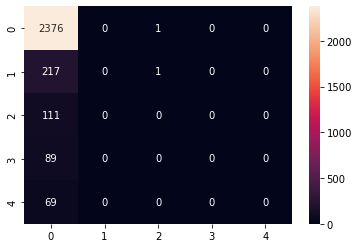

In [88]:
lr = LogisticRegression(solver='newton-cg', max_iter = 100000)
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred = lr.predict(X_test)
print(y_pred)
print(y_test.to_numpy())

cm_train = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_train, annot=True, fmt='d')

<AxesSubplot:>

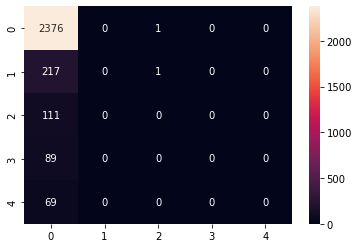

In [89]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier( criterion='gini',splitter = 'best', min_samples_leaf=2, min_samples_split=2)
dt.fit(X_train, y_train)
y_dt = dt.predict(X_test)

y_dt_train =  dt.predict(X_train)

cm = confusion_matrix(y_test, y_dt)
sns.heatmap(cm_train, annot=True, fmt='d')

The results are the same for logistic regression and decision tree. All predicted values are assigned to the same class. This is due to the fact that class 0 is the most popular. Data needs to be resampled to reach better results.

In [90]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=42)
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

[2 2 4 ... 4 4 3]
[0 4 0 ... 0 1 0]


<AxesSubplot:>

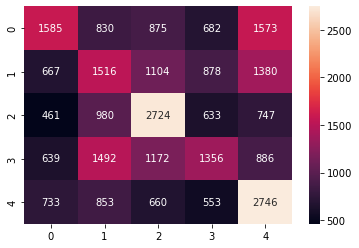

In [91]:
lr = LogisticRegression(solver='newton-cg', max_iter = 100000)
lr.fit(Xsm_train, ysm_train)

y_pred_train = lr.predict(Xsm_train)
y_pred = lr.predict(X_test)
print(y_pred)
print(y_test.to_numpy())

cm_train = confusion_matrix(ysm_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d')

In [92]:
accuracy_train = accuracy_score(ysm_train, y_pred_train)
print(f'Accuracy: {accuracy_train}')

accuracy_test = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy_test}')

Accuracy: 0.35805229936880073
Accuracy: 0.28666201117318435


<AxesSubplot:>

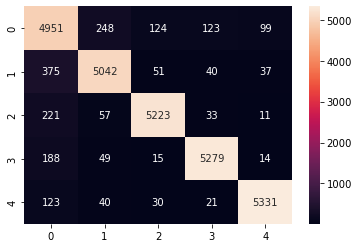

In [93]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier( criterion='gini',splitter = 'best', min_samples_leaf=4, min_samples_split=4)
dt.fit(Xsm_train, ysm_train)
y_dt = dt.predict(X_test)

y_dt_train =  dt.predict(Xsm_train)

cm = confusion_matrix(ysm_train, y_dt_train)
sns.heatmap(cm, annot=True, fmt='d')

In [94]:
accuracy_train = accuracy_score(ysm_train, y_dt_train)
print(f'Accuracy: {accuracy_train}')

accuracy_test = accuracy_score(y_test, y_dt)
print(f'Accuracy: {accuracy_test}')

Accuracy: 0.9315058611361587
Accuracy: 0.590782122905028


After applying SMOTE the results are a bit better but we still dealing with over overfitting. Train accuracy is much better than test accuracy. Let's try more sophisticated models to try to reach better accuracy.

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('classifier', RandomForestClassifier())])

param = {'classifier__n_estimators': [150, 200, 250]}

grid = GridSearchCV(pipe, param,cv=20, return_train_score=False,verbose=True, n_jobs=-1)
grid.fit(Xsm_train, ysm_train)
grid.best_params_
print("Best parameter (CV score=%0.3f):" % grid.best_score_)

y_rf = grid.predict(X_test)

accuracy_test = accuracy_score(y_test, y_rf)
print(f'Accuracy: {accuracy_test}')


Fitting 20 folds for each of 3 candidates, totalling 60 fits
Best parameter (CV score=0.968):
Accuracy: 0.7566340782122905


<AxesSubplot:>

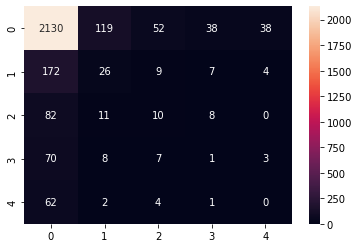

In [96]:
confusion_forest=confusion_matrix(y_test, y_rf)
sns.heatmap(confusion_forest, annot=True, fmt='d')

In [97]:
from sklearn.metrics import f1_score
f1_rf = f1_score(y_rf, y_test, average='macro')
print(f'F1 score: {f1_rf}')

F1 score: 0.22471280259381504


In [98]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC

pipe = Pipeline([('classifier', BaggingClassifier(base_estimator = SVC()))])

param = {'classifier__n_estimators': [1,25]}

grid = GridSearchCV(pipe, param,cv=4, return_train_score=False,verbose=True, n_jobs=-1)
grid.fit(Xsm_train, ysm_train)
grid.best_params_
print("Best parameter (CV score=%0.3f):" % grid.best_score_)

y_bc = grid.predict(X_test)

accuracy_test = accuracy_score(y_test, y_bc)
print(f'Accuracy: {accuracy_test}')


Fitting 4 folds for each of 2 candidates, totalling 8 fits
Best parameter (CV score=0.762):
Accuracy: 0.5185055865921788


<AxesSubplot:>

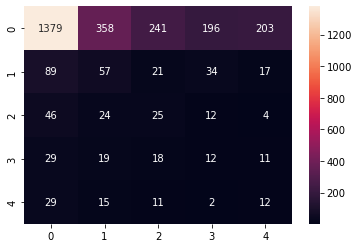

In [99]:
confusion_bagging=confusion_matrix(y_test, y_bc)
sns.heatmap(confusion_bagging, annot=True, fmt='d')

In [100]:
f1_bc = f1_score(y_bc, y_test, average='macro')
print(f'F1 score: {f1_bc}')

F1 score: 0.22519871099053526


In [101]:
pipe = Pipeline([('classifier', GradientBoostingClassifier())])

param = {'classifier__n_estimators': [100,150]}

grid = GridSearchCV(pipe, param,cv=15, return_train_score=False,verbose=True, n_jobs=-1)
grid.fit(Xsm_train, ysm_train)
grid.best_params_
print("Best parameter (CV score=%0.3f):" % grid.best_score_)

y_gbc = grid.predict(X_test)

accuracy_test = accuracy_score(y_test, y_gbc)
print(f'Accuracy: {accuracy_test}')


Fitting 15 folds for each of 2 candidates, totalling 30 fits
Best parameter (CV score=0.686):
Accuracy: 0.5380586592178771


<AxesSubplot:>

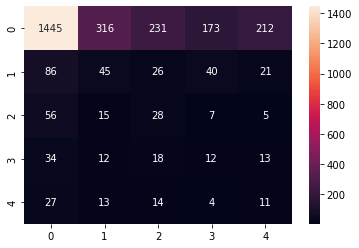

In [102]:
confusion_gbc=confusion_matrix(y_test, y_gbc)
sns.heatmap(confusion_gbc, annot=True, fmt='d')

In [103]:
f1_gbc = f1_score(y_gbc, y_test, average='macro')
print(f'F1 score: {f1_gbc}')

F1 score: 0.22691215083524216


In [104]:
pipe = Pipeline([('classifier', xgb.XGBClassifier())])

param = {'classifier__n_estimators': [200,250,300], 'classifier__learning_rate': [0.1,0.25,0.05],
         'classifier__max_depth':[8,10,12]}

grid = GridSearchCV(pipe, param,cv=10, return_train_score=False,verbose=True, n_jobs=-1)
grid.fit(Xsm_train, ysm_train)
grid.best_params_
print("Best parameter (CV score=%0.3f):" % grid.best_score_)

y_gbc = grid.predict(X_test)

accuracy_test = accuracy_score(y_test, y_gbc)
print(f'Accuracy: {accuracy_test}')


Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameter (CV score=0.958):
Accuracy: 0.7402234636871509


<AxesSubplot:>

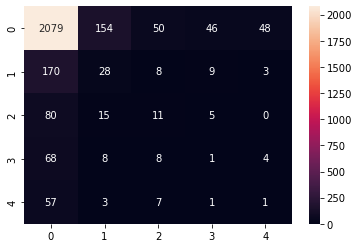

In [105]:
confusion_xgb=confusion_matrix(y_test, y_gbc)
sns.heatmap(confusion_xgb, annot=True, fmt='d')

In [106]:
f1_xgb = f1_score(y_gbc, y_test, average='macro')
print(f'F1 score: {f1_xgb}')

F1 score: 0.22684246264817368


The results for Random Forest, Bagging Classifier, Gradient Boosing and XGBoost are similar. More sophisticated models are dealing with the data better than Logistic Regression and Decision Tree, but the problem is still the same - model has a big problem with assigning to classes 1,2,3 and 4. Accuracy around 75% is not a bad result but low F1 score and confusion matrix show that high accuracy is caused by the fact that majority of the data belongs to class 0.

In [107]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import classification_report,confusion_matrix

In [108]:
Xsm_train.shape

(27725, 29)

In [109]:
ysm_train.nunique()

5

For deep learning model I applied relu activation for each layer and softmax for the last layer to give results for 5 classes. I applied dropuut to avoid overfitting and used sparse categorical crossentropy to monitor the loss.

In [110]:
model = Sequential()

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5,activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

In [111]:
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',verbose=1,
                          patience=200,restore_best_weights=True)

In [112]:
model.fit(x=Xsm_train,y=ysm_train,epochs=200,
          validation_split=0.2,
         callbacks=[early_stop])

Epoch 1/200
694/694 [==============================] - 8s 7ms/step - loss: 1.3872 - accuracy: 0.3349 - val_loss: 4.2790 - val_accuracy: 0.0200
Epoch 2/200
694/694 [==============================] - 5s 7ms/step - loss: 1.2747 - accuracy: 0.4249 - val_loss: 4.2152 - val_accuracy: 0.0173
Epoch 3/200
694/694 [==============================] - 5s 7ms/step - loss: 1.1902 - accuracy: 0.4847 - val_loss: 4.1586 - val_accuracy: 0.0229
Epoch 4/200
694/694 [==============================] - 5s 8ms/step - loss: 1.1125 - accuracy: 0.5303 - val_loss: 4.3704 - val_accuracy: 0.0261
Epoch 5/200
694/694 [==============================] - 5s 7ms/step - loss: 1.0468 - accuracy: 0.5705 - val_loss: 4.2980 - val_accuracy: 0.0274
Epoch 6/200
694/694 [==============================] - 4s 6ms/step - loss: 0.9935 - accuracy: 0.5977 - val_loss: 4.2468 - val_accuracy: 0.0269
Epoch 7/200
694/694 [==============================] - 5s 7ms/step - loss: 0.9551 - accuracy: 0.6187 - val_loss: 4.4237 - val_accuracy: 0.0265

Epoch 58/200
694/694 [==============================] - 5s 8ms/step - loss: 0.5911 - accuracy: 0.7839 - val_loss: 4.3224 - val_accuracy: 0.0285
Epoch 59/200
694/694 [==============================] - 6s 8ms/step - loss: 0.5882 - accuracy: 0.7844 - val_loss: 4.3811 - val_accuracy: 0.0285
Epoch 60/200
694/694 [==============================] - 6s 8ms/step - loss: 0.5843 - accuracy: 0.7844 - val_loss: 4.3289 - val_accuracy: 0.0285
Epoch 61/200
694/694 [==============================] - 5s 8ms/step - loss: 0.5879 - accuracy: 0.7856 - val_loss: 4.4777 - val_accuracy: 0.0285
Epoch 62/200
694/694 [==============================] - 6s 8ms/step - loss: 0.5812 - accuracy: 0.7896 - val_loss: 4.2874 - val_accuracy: 0.0285
Epoch 63/200
694/694 [==============================] - 5s 7ms/step - loss: 0.5791 - accuracy: 0.7860 - val_loss: 4.3989 - val_accuracy: 0.0289
Epoch 64/200
694/694 [==============================] - 5s 7ms/step - loss: 0.5765 - accuracy: 0.7909 - val_loss: 4.3164 - val_accuracy:

694/694 [==============================] - 7s 10ms/step - loss: 0.5313 - accuracy: 0.8072 - val_loss: 4.3800 - val_accuracy: 0.0287
Epoch 115/200
694/694 [==============================] - 7s 10ms/step - loss: 0.5248 - accuracy: 0.8094 - val_loss: 4.3651 - val_accuracy: 0.0289
Epoch 116/200
694/694 [==============================] - 6s 9ms/step - loss: 0.5264 - accuracy: 0.8131 - val_loss: 4.4962 - val_accuracy: 0.0287
Epoch 117/200
694/694 [==============================] - 6s 9ms/step - loss: 0.5271 - accuracy: 0.8125 - val_loss: 4.5796 - val_accuracy: 0.0289
Epoch 118/200
694/694 [==============================] - 7s 10ms/step - loss: 0.5275 - accuracy: 0.8132 - val_loss: 4.3789 - val_accuracy: 0.0287
Epoch 119/200
694/694 [==============================] - 7s 10ms/step - loss: 0.5263 - accuracy: 0.8106 - val_loss: 4.4518 - val_accuracy: 0.0287
Epoch 120/200
694/694 [==============================] - 7s 9ms/step - loss: 0.5248 - accuracy: 0.8107 - val_loss: 4.4539 - val_accuracy: 0.

694/694 [==============================] - 6s 9ms/step - loss: 0.4985 - accuracy: 0.8214 - val_loss: 4.3939 - val_accuracy: 0.0289
Epoch 171/200
694/694 [==============================] - 6s 9ms/step - loss: 0.5060 - accuracy: 0.8202 - val_loss: 4.4258 - val_accuracy: 0.0289
Epoch 172/200
694/694 [==============================] - 6s 9ms/step - loss: 0.5024 - accuracy: 0.8216 - val_loss: 4.2875 - val_accuracy: 0.0285
Epoch 173/200
694/694 [==============================] - 6s 9ms/step - loss: 0.5018 - accuracy: 0.8216 - val_loss: 4.3862 - val_accuracy: 0.0285
Epoch 174/200
694/694 [==============================] - 6s 9ms/step - loss: 0.4997 - accuracy: 0.8224 - val_loss: 4.2901 - val_accuracy: 0.0289
Epoch 175/200
694/694 [==============================] - 6s 9ms/step - loss: 0.5016 - accuracy: 0.8225 - val_loss: 4.3139 - val_accuracy: 0.0287
Epoch 176/200
694/694 [==============================] - 7s 9ms/step - loss: 0.5042 - accuracy: 0.8193 - val_loss: 4.3793 - val_accuracy: 0.0287

In [113]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
predictions = np.argmax(predictions, axis = 1)
predictions

90/90 [==============================] - 1s 6ms/step


array([2, 2, 0, ..., 0, 2, 0], dtype=int64)

In [114]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.87      0.69      0.77      2377
           1       0.13      0.39      0.20       218
           2       0.04      0.05      0.04       111
           3       0.05      0.09      0.06        89
           4       0.00      0.00      0.00        69

    accuracy                           0.61      2864
   macro avg       0.22      0.24      0.21      2864
weighted avg       0.74      0.61      0.66      2864



In [115]:
print(confusion_matrix(y_test,predictions))

[[1647  477  130  123    0]
 [  99   84   12   23    0]
 [  67   28    6   10    0]
 [  40   31   10    8    0]
 [  37   23    4    5    0]]


The results are a bit better than for other models the problem is still the same. Classes 1-4 are difficult to predict andthe reslts for them are very poor. 

I will try to fix this by merging classes 1-4 into one and apply the models once again.

In [116]:
#new dataframe to assign two classes
df_model_two_classes = df_all[['play_pattern_name', 'team_name', 'player_name',
       'position_name', 'pass_recipient_name', 'pass_length', 'pass_angle',
       'pass_height_name', 'end_x', 'end_y', 'body_part_name', 'sub_type_name',
       'x', 'y', 'outcome_name', 'under_pressure', 'pass_cross', 'pass_switch',
       'time', 'cross_outcome']]
df_model_two_classes = df_model_two_classes[df_model_two_classes['pass_cross']==True]
df_model_two_classes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9545 entries, 232 to 1313478
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   play_pattern_name    9545 non-null   object 
 1   team_name            9545 non-null   object 
 2   player_name          9545 non-null   object 
 3   position_name        9545 non-null   object 
 4   pass_recipient_name  6871 non-null   object 
 5   pass_length          9545 non-null   object 
 6   pass_angle           9545 non-null   object 
 7   pass_height_name     9545 non-null   object 
 8   end_x                9545 non-null   object 
 9   end_y                9545 non-null   object 
 10  body_part_name       9434 non-null   object 
 11  sub_type_name        998 non-null    object 
 12  x                    9545 non-null   object 
 13  y                    9545 non-null   object 
 14  outcome_name         6921 non-null   object 
 15  under_pressure       1086 non-nul

In [117]:
#repeat all pre-processing activities to prepare the data
df_model_two_classes.drop('pass_recipient_name',axis=1,inplace=True)
df_model_two_classes['body_part_name'].replace(['Drop Kick','No Touch'],'Other',inplace=True)
df_model_two_classes['body_part_name'].fillna('Other',inplace=True)
df_model_two_classes['sub_type_name'].fillna('Open play',inplace=True)
df_model_two_classes.drop('outcome_name',axis=1,inplace=True)
df_model_two_classes['under_pressure'].fillna(0,inplace=True)
df_model_two_classes['pass_switch'].replace(True,1,inplace=True)
df_model_two_classes['pass_switch'].fillna(0,inplace=True)
df_model_two_classes['play_pattern_name'].replace(['From Free Kick','From Corner'],'From Free Kick/Corner',inplace=True)
df_model_two_classes['play_pattern_name'].replace(['From Goal Kick','From Kick Off','From Keeper','From Counter'],'Other',inplace=True)
df_model_two_classes.drop(['team_name','player_name'],axis=1,inplace=True)
df_model_two_classes['position_name'].replace(['Left Back','Right Back','Left Wing Back','Right Wing Back'],'Full Back',inplace=True)
df_model_two_classes['position_name'].replace(['Right Wing','Left Wing','Left Midfield','Right Midfield'],'Winger',inplace=True)
df_model_two_classes['position_name'].replace(['Center Forward','Left Center Forward','Right Center Forward'],'Forward',inplace=True)
df_model_two_classes['position_name'].replace(['Center Attacking Midfield','Right Center Midfield','Left Center Midfield',
                                  'Right Attacking Midfield','Left Attacking Midfield'],'Offensive Midfielder',inplace=True)
df_model_two_classes['position_name'].replace(['Right Defensive Midfield','Left Defensive Midfield','Right Center Back',
                                  'Center Defensive Midfield','Left Center Back','Center Back'],'Defender',inplace=True)
df_model_two_classes.drop('pass_cross',axis=1,inplace=True)
df_model_two_classes[['x','y','end_x','end_y','pass_length','pass_angle']]=df_model_two_classes[['x','y','end_x','end_y','pass_length',
                                                                         'pass_angle']].astype(float)
#get one hot encoding of columns with dtype=object
one_hot_two_classes = pd.get_dummies(df_model_two_classes[['play_pattern_name','position_name','pass_height_name','body_part_name',
                                   'sub_type_name']])
#drop encoded columns
df_model_two_classes.drop(['play_pattern_name','position_name','pass_height_name','body_part_name',
               'sub_type_name'],axis = 1,inplace=True)
#join the encoded dataframe
df_model_two_classes = df_model_two_classes.join(one_hot_two_classes)


In [118]:
# assign only classes 0 and 1 this time
class_mapping_two_classes = {'No shot':0,'Off T':1,'Blocked':1,'Saved':1,'Goal':1}
df_model_two_classes['cross_outcome'] = df_model_two_classes['cross_outcome'].map(class_mapping_two_classes)

In [119]:
y = df_model_two_classes['cross_outcome']
X = df_model_two_classes.drop('cross_outcome',axis=1)

In [120]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X.describe()

0             1             2             3             4   \
count  9.545000e+03  9.545000e+03  9.545000e+03  9.545000e+03  9.545000e+03   
mean  -2.105527e-16  4.315272e-17 -2.357232e-16 -8.447931e-17  8.318821e-17   
std    1.000052e+00  1.000052e+00  1.000052e+00  1.000052e+00  1.000052e+00   
min   -2.288601e+00 -1.789529e+00 -6.890665e+00 -3.732655e+00 -2.261310e+00   
25%   -6.535204e-01 -9.519769e-01 -6.303122e-01 -4.774061e-01 -7.607618e-01   
50%   -8.808618e-02 -5.747149e-01 -1.741057e-02  2.917435e-02  1.863927e-01   
75%    5.112606e-01  9.979646e-01  7.049378e-01  5.076115e-01  8.249238e-01   
max    3.922147e+00  1.964966e+00  1.865073e+00  3.762860e+00  1.548592e+00   

                 5             6             7             8             9   \
count  9.545000e+03  9.545000e+03  9.545000e+03  9.545000e+03  9.545000e+03   
mean  -2.028527e-17  8.233098e-16 -7.331427e-16 -1.367860e-17  1.931288e-16   
std    1.000052e+00  1.000052e+00  1.000052e+00  1.000052e+00  1.000052e+00   
min   -1.417013e+00 -3.583071e-01 -4.391205e-01 -1.817051e+00 -6.408823e-01   
25%   -1.020632e+00 -3.583071e-01 -4.391205e-01 -8.433242e-01 -6.408823e-01   
50%    5.127386e-01 -3.583071e-01 -4.391205e-01  1.403363e-02 -6.408823e-01   
75%    9.786606e-01 -3.583071e-01 -4.391205e-01  8.474886e-01  1.560349e+00   
max    1.357657e+00  2.790902e+00  2.277279e+00  1.897327e+00  1.560349e+00   

       ...            19            20            21            22  \
count  ...  9.545000e+03  9.545000e+03  9.545000e+03  9.545000e+03   
mean   ... -3.483855e-16  3.178995e-16  1.675524e-15 -4.769830e-16   
std    ...  1.000052e+00  1.000052e+00  1.000052e+00  1.000052e+00   
min    ... -1.548159e+00 -4.021909e-01 -9.193581e-02 -8.191724e-01   
25%    ... -1.548159e+00 -4.021909e-01 -9.193581e-02 -8.191724e-01   
50%    ...  6.459284e-01 -4.021909e-01 -9.193581e-02 -8.191724e-01   
75%    ...  6.459284e-01 -4.021909e-01 -9.193581e-02  1.220744e+00   
max    ...  6.459284e-01  2.486381e+00  1.087715e+01  1.220744e+00   

                 23            24            25            26            27  \
count  9.545000e+03  9.545000e+03  9.545000e+03  9.545000e+03  9.545000e+03   
mean  -8.529671e-16  6.257726e-17  1.532794e-16 -5.912272e-17  1.541425e-15   
std    1.000052e+00  1.000052e+00  1.000052e+00  1.000052e+00  1.000052e+00   
min   -1.104315e-01 -1.170326e+00 -2.947580e-01 -2.926453e+00 -1.358648e-01   
25%   -1.104315e-01 -1.170326e+00 -2.947580e-01  3.417106e-01 -1.358648e-01   
50%   -1.104315e-01  8.544630e-01 -2.947580e-01  3.417106e-01 -1.358648e-01   
75%   -1.104315e-01  8.544630e-01 -2.947580e-01  3.417106e-01 -1.358648e-01   
max    9.055385e+00  8.544630e-01  3.392614e+00  3.417106e-01  7.360259e+00   

                 28  
count  9.545000e+03  
mean   7.314125e-16  
std    1.000052e+00  
min   -8.085800e-02  
25%   -8.085800e-02  
50%   -8.085800e-02  
75%   -8.085800e-02  
max    1.236736e+01  

[8 rows x 29 columns]

In [121]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)

In [122]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority', k_neighbors=4, random_state=42)
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

In [123]:
ysm_train.value_counts()

0    5545
1    5545
Name: cross_outcome, dtype: int64

[0 1 1 ... 0 1 0]
[0 1 0 ... 1 0 0]


<AxesSubplot:>

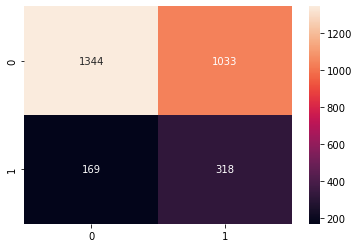

In [124]:
lr = LogisticRegression(solver='newton-cg', max_iter = 100000)
lr.fit(Xsm_train, ysm_train)

y_pred_train = lr.predict(Xsm_train)
y_pred = lr.predict(X_test)
print(y_pred)
print(y_test.to_numpy())

cm_train = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_train, annot=True, fmt='d')

In [125]:
accuracy_train = accuracy_score(ysm_train, y_pred_train)
print(f'Accuracy: {accuracy_train}')

accuracy_test = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy_test}')

Accuracy: 0.6295761947700631
Accuracy: 0.5803072625698324


<AxesSubplot:>

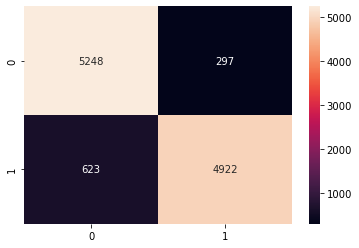

In [126]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier( criterion='gini',splitter = 'best',max_depth=10000, min_samples_leaf=4, min_samples_split=4)
dt.fit(Xsm_train, ysm_train)
y_dt = dt.predict(X_test)

y_dt_train =  dt.predict(Xsm_train)
y_dt_pred =  dt.predict(X_test)

cm = confusion_matrix(ysm_train, y_dt_train)
sns.heatmap(cm, annot=True, fmt='d')

In [127]:
accuracy_train = accuracy_score(ysm_train, y_dt_train)
print(f'Accuracy: {accuracy_train}')

accuracy_test = accuracy_score(y_test, y_dt)
print(f'Accuracy: {accuracy_test}')

Accuracy: 0.9170423805229937
Accuracy: 0.6888966480446927


In [128]:
print(classification_report(y_test,y_dt_pred))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80      2377
           1       0.24      0.38      0.29       487

    accuracy                           0.69      2864
   macro avg       0.55      0.57      0.55      2864
weighted avg       0.75      0.69      0.71      2864



Logistic regression and Decision Tree results have improved a little but are still much worse for class 1 compared to class 0. Let's see if Random Forest can get a better result than with 5 classes.

In [129]:
pipe = Pipeline([('classifier', RandomForestClassifier())])

param = {'classifier__n_estimators': [200, 250]}

grid = GridSearchCV(pipe, param,cv=15, return_train_score=False,verbose=True, n_jobs=-1)
grid.fit(Xsm_train, ysm_train)
grid.best_params_
print("Best parameter (CV score=%0.3f):" % grid.best_score_)

y_rf = grid.predict(X_test)

accuracy_test = accuracy_score(y_test, y_rf)
print(f'Accuracy: {accuracy_test}')


Fitting 15 folds for each of 2 candidates, totalling 30 fits
Best parameter (CV score=0.876):
Accuracy: 0.7513966480446927


<AxesSubplot:>

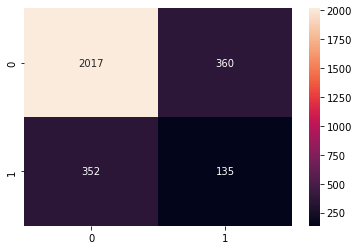

In [130]:
confusion_forest=confusion_matrix(y_test, y_rf)
sns.heatmap(confusion_forest, annot=True, fmt='d')

In [131]:
print(classification_report(y_test,y_rf))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2377
           1       0.27      0.28      0.27       487

    accuracy                           0.75      2864
   macro avg       0.56      0.56      0.56      2864
weighted avg       0.75      0.75      0.75      2864



The result for Random Forest is a bit better. Let's see if we can get even better result with deep learning.

This time I can use binary crossentropy and sigmoid activation function because there are only two classes

In [132]:
model = Sequential()

model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'] )

In [133]:
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',verbose=1,
                          patience=3,restore_best_weights=True)

In [134]:
model.fit(x=Xsm_train,y=ysm_train,epochs=10,batch_size=128,
          validation_split=0.2,
         callbacks=[early_stop])

Epoch 1/10
70/70 [==============================] - 6s 37ms/step - loss: 0.6194 - accuracy: 0.6371 - val_loss: 0.7471 - val_accuracy: 0.5329
Epoch 2/10
70/70 [==============================] - 2s 28ms/step - loss: 0.5800 - accuracy: 0.6687 - val_loss: 0.7004 - val_accuracy: 0.6041
Epoch 3/10
70/70 [==============================] - 2s 29ms/step - loss: 0.5466 - accuracy: 0.6953 - val_loss: 0.5919 - val_accuracy: 0.7511
Epoch 4/10
70/70 [==============================] - 2s 29ms/step - loss: 0.5239 - accuracy: 0.7174 - val_loss: 0.6319 - val_accuracy: 0.6628
Epoch 5/10
70/70 [==============================] - 2s 30ms/step - loss: 0.5022 - accuracy: 0.7364 - val_loss: 0.5570 - val_accuracy: 0.7737
Epoch 6/10
70/70 [==============================] - 2s 30ms/step - loss: 0.4808 - accuracy: 0.7541 - val_loss: 0.5541 - val_accuracy: 0.7638
Epoch 7/10
70/70 [==============================] - 2s 33ms/step - loss: 0.4687 - accuracy: 0.7619 - val_loss: 0.5720 - val_accuracy: 0.7403
Epoch 8/10
70

In [135]:
predictions_two_classes = (model.predict(X_test) > 0.5).astype("int32")
predictions_two_classes = np.argmax(predictions_two_classes, axis = 1)
predictions_two_classes

90/90 [==============================] - 1s 6ms/step


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [136]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions_two_classes))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2377
           1       0.00      0.00      0.00       487

    accuracy                           0.83      2864
   macro avg       0.41      0.50      0.45      2864
weighted avg       0.69      0.83      0.75      2864



Turns out with this model we are back to the initial problem with only one class being assigned in the prediction. In the next step, I will try applying softmax activation and categorical crossentropy for two classes.

In [137]:
model = Sequential()

model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16,activation='relu'))
model.add(Dense(2,activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

In [138]:
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',verbose=1,
                          patience=3,restore_best_weights=True)

In [139]:
model.fit(x=Xsm_train,y=ysm_train,epochs=10,batch_size=128,
          validation_split=0.2,
         callbacks=[early_stop])

Epoch 1/10
70/70 [==============================] - 9s 40ms/step - loss: 0.6249 - accuracy: 0.6309 - val_loss: 0.8176 - val_accuracy: 0.1993
Epoch 2/10
70/70 [==============================] - 2s 30ms/step - loss: 0.5845 - accuracy: 0.6666 - val_loss: 0.7336 - val_accuracy: 0.4937
Epoch 3/10
70/70 [==============================] - 2s 32ms/step - loss: 0.5531 - accuracy: 0.6924 - val_loss: 0.6405 - val_accuracy: 0.6519
Epoch 4/10
70/70 [==============================] - 2s 31ms/step - loss: 0.5251 - accuracy: 0.7140 - val_loss: 0.6928 - val_accuracy: 0.5924
Epoch 5/10
70/70 [==============================] - 2s 31ms/step - loss: 0.5067 - accuracy: 0.7280 - val_loss: 0.7536 - val_accuracy: 0.5198
Epoch 6/10
70/70 [==============================] - 2s 30ms/step - loss: 0.4880 - accuracy: 0.7510 - val_loss: 0.5701 - val_accuracy: 0.7417
Epoch 7/10
70/70 [==============================] - 2s 32ms/step - loss: 0.4666 - accuracy: 0.7621 - val_loss: 0.5150 - val_accuracy: 0.7949
Epoch 8/10
70

In [140]:
predictions_two_classes = (model.predict(X_test) > 0.5).astype("int32")
predictions_two_classes = np.argmax(predictions_two_classes, axis = 1)
predictions_two_classes

90/90 [==============================] - 1s 5ms/step


array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [141]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions_two_classes))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      2377
           1       0.27      0.43      0.33       487

    accuracy                           0.70      2864
   macro avg       0.57      0.59      0.57      2864
weighted avg       0.76      0.70      0.73      2864



In [142]:
sm = SMOTE(sampling_strategy='minority', k_neighbors=4, random_state=42)
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

In [143]:
model = Sequential()

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2,activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

In [144]:
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',verbose=1,
                          patience=3,restore_best_weights=True)

In [145]:
model.fit(x=Xsm_train,y=ysm_train,epochs=50,batch_size=512,
          validation_split=0.2,
         callbacks=[early_stop])

Epoch 1/50
18/18 [==============================] - 5s 74ms/step - loss: 0.6524 - accuracy: 0.6214 - val_loss: 0.8669 - val_accuracy: 0.0275
Epoch 2/50
18/18 [==============================] - 1s 48ms/step - loss: 0.6260 - accuracy: 0.6319 - val_loss: 0.8144 - val_accuracy: 0.2714
Epoch 3/50
18/18 [==============================] - 1s 46ms/step - loss: 0.6098 - accuracy: 0.6417 - val_loss: 0.8048 - val_accuracy: 0.4004
Epoch 4/50
18/18 [==============================] - 1s 47ms/step - loss: 0.5976 - accuracy: 0.6544 - val_loss: 0.7904 - val_accuracy: 0.4883
Epoch 5/50
18/18 [==============================] - 1s 47ms/step - loss: 0.5817 - accuracy: 0.6670 - val_loss: 0.7023 - val_accuracy: 0.6718
Epoch 6/50
18/18 [==============================] - 1s 43ms/step - loss: 0.5761 - accuracy: 0.6711 - val_loss: 0.7309 - val_accuracy: 0.6073
Epoch 7/50
18/18 [==============================] - 1s 44ms/step - loss: 0.5683 - accuracy: 0.6746 - val_loss: 0.7450 - val_accuracy: 0.5987
Epoch 8/50
18

In [146]:
predictions_two_classes = (model.predict(X_test) > 0.5).astype("int32")
predictions_two_classes = np.argmax(predictions_two_classes, axis = 1)
predictions_two_classes

90/90 [==============================] - 1s 6ms/step


array([0, 1, 1, ..., 0, 1, 0], dtype=int64)

In [147]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions_two_classes))

              precision    recall  f1-score   support

           0       0.87      0.70      0.78      2377
           1       0.26      0.50      0.34       487

    accuracy                           0.67      2864
   macro avg       0.56      0.60      0.56      2864
weighted avg       0.77      0.67      0.70      2864



The improvement is minimal for class 1 and for class 0 the result is even a it worse. The next thing I will try is to manually decrease the number of records with class 0 by dropping some of the values from the initial dataframe.

First I will check where are all the crosses directed on the pitch and where are the shots from crosses coming from. Based on this I will drop all the crosses directed to the areas that are unlikely or even impossible to score from. This could go both ways for my model. Either it will result in worse predictions because a lot of information will be lost or it can improve the result because the number of instances for class 1 should remain on similar level, while the number of instances of class 0 should reduce. Let's try this and see the results.

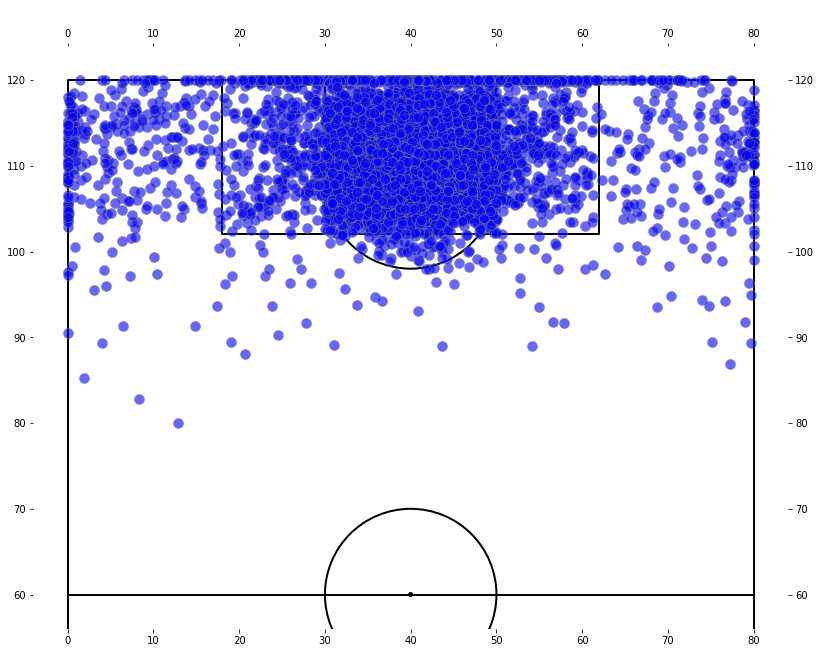

In [148]:
#plot vertical pitch
pitch = VerticalPitch(line_color='black',half=True,label=True,tick=True)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, 
                         endnote_height=0.04, title_space=0, endnote_space=0)
#scatter the location of all the crosses received
pitch.scatter(df_model_two_classes['end_x'], df_model_two_classes['end_y'], s=100, color='blue', 
                      edgecolors='grey', linewidth=0.8, alpha=0.6, ax=ax["pitch"])

In [149]:
#create new dataframe only with crosses that lead to shots and their end coordinates
df_shots_from_crosses = df_all[['end_x', 'end_y','cross_outcome','pass_cross']]
df_shots_from_crosses = df_shots_from_crosses[(df_shots_from_crosses['pass_cross']==True) & 
                                             ((df_shots_from_crosses['cross_outcome']!='No shot'))]
df_shots_from_crosses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1623 entries, 436 to 1311488
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   end_x          1623 non-null   object
 1   end_y          1623 non-null   object
 2   cross_outcome  1623 non-null   object
 3   pass_cross     1623 non-null   object
dtypes: object(4)
memory usage: 63.4+ KB


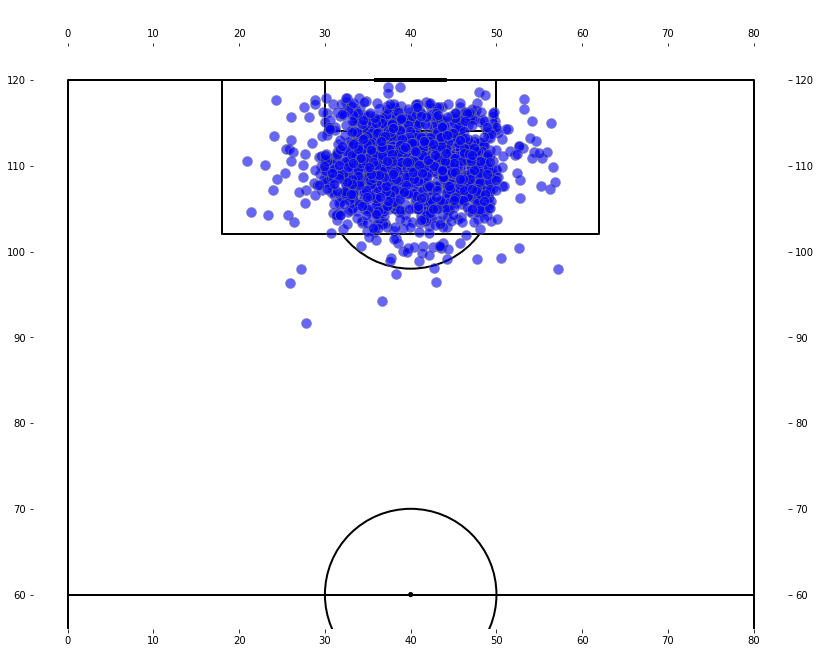

In [150]:
#plot vertical pitch
pitch = VerticalPitch(line_color='black',half=True,label=True,tick=True)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, 
                         endnote_height=0.04, title_space=0, endnote_space=0)
#scatter the location of crosses received that ended up in a shot being made
pitch.scatter(df_shots_from_crosses['end_x'], df_shots_from_crosses['end_y'], s=100, color='blue', 
                      edgecolors='grey', linewidth=0.8, alpha=0.6, ax=ax["pitch"])

Majority of shots made after crosses is from the middle of the penalty area. Using x,y coordinates this area can be described as 30 < y < 50 and 103 < x < 118 (the above plot is in vertical position). We can call this a dangerous area. If we leave only crosses directed into the dangerous area, maybe our model will have better results.

In [152]:
#create new dataframe only with crosses directed into the dangerous area
df_model_two_classes_small = df_model_two_classes[(df_model_two_classes['end_y'].between(30,50)) & 
                                                  (df_model_two_classes['end_x'].between(103,118))]

In [153]:
y = df_model_two_classes_small['cross_outcome']
X = df_model_two_classes_small.drop('cross_outcome',axis=1)

In [157]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X.describe()

0             1             2             3             4   \
count  7.607000e+03  7.607000e+03  7.607000e+03  7.607000e+03  7.607000e+03   
mean  -4.435346e-17 -6.659587e-17 -3.189246e-15 -1.792995e-15 -4.677911e-16   
std    1.000066e+00  1.000066e+00  1.000066e+00  1.000066e+00  1.000066e+00   
min   -2.855607e+00 -1.790456e+00 -2.295103e+00 -1.913677e+00 -2.281274e+00   
25%   -6.800396e-01 -9.553746e-01 -6.909545e-01 -8.401253e-01 -7.588797e-01   
50%    7.583292e-02 -5.660643e-01  1.261938e-02  2.624958e-02  1.866075e-01   
75%    7.198334e-01  9.965903e-01  7.443362e-01  8.549559e-01  8.276158e-01   
max    2.932086e+00  1.960773e+00  1.926340e+00  1.853170e+00  1.543408e+00   

                 5             6             7             8             9   \
count  7.607000e+03  7.607000e+03  7.607000e+03  7.607000e+03  7.607000e+03   
mean   1.618266e-16 -1.134012e-15  3.705973e-16  6.900400e-17  1.658840e-16   
std    1.000066e+00  1.000066e+00  1.000066e+00  1.000066e+00  1.000066e+00   
min   -1.415081e+00 -3.459254e-01 -2.036765e-01 -1.819493e+00 -6.544283e-01   
25%   -1.018867e+00 -3.459254e-01 -2.036765e-01 -8.356836e-01 -6.544283e-01   
50%    4.964743e-01 -3.459254e-01 -2.036765e-01  6.638085e-03 -6.544283e-01   
75%    9.795763e-01 -3.459254e-01 -2.036765e-01  8.536760e-01  1.528051e+00   
max    1.354936e+00  2.890796e+00  4.909746e+00  1.893766e+00  1.528051e+00   

       ...            19            20            21            22  \
count  ...  7.607000e+03  7.607000e+03  7.607000e+03  7.607000e+03   
mean   ... -7.258264e-16 -3.083434e-16  3.895158e-16  3.830248e-16   
std    ...  1.000066e+00  1.000066e+00  1.000066e+00  1.000066e+00   
min    ... -1.428840e+00 -4.291307e-01 -1.011225e-01 -8.143069e-01   
25%    ... -1.428840e+00 -4.291307e-01 -1.011225e-01 -8.143069e-01   
50%    ...  6.998685e-01 -4.291307e-01 -1.011225e-01 -8.143069e-01   
75%    ...  6.998685e-01 -4.291307e-01 -1.011225e-01  1.228038e+00   
max    ...  6.998685e-01  2.330292e+00  9.888994e+00  1.228038e+00   

                 23            24            25            26            27  \
count  7.607000e+03  7.607000e+03  7.607000e+03  7.607000e+03  7.607000e+03   
mean   2.717142e-16  6.404179e-17  6.779264e-17 -1.796760e-16 -9.533294e-17   
std    1.000066e+00  1.000066e+00  1.000066e+00  1.000066e+00  1.000066e+00   
min   -1.188758e-01 -1.168486e+00 -3.087400e-01 -2.800955e+00 -1.359278e-01   
25%   -1.188758e-01 -1.168486e+00 -3.087400e-01  3.570211e-01 -1.359278e-01   
50%   -1.188758e-01  8.558079e-01 -3.087400e-01  3.570211e-01 -1.359278e-01   
75%   -1.188758e-01  8.558079e-01 -3.087400e-01  3.570211e-01 -1.359278e-01   
max    8.412143e+00  8.558079e-01  3.238972e+00  3.570211e-01  7.356846e+00   

                 28  
count  7.607000e+03  
mean   1.966643e-18  
std    1.000066e+00  
min   -8.916378e-02  
25%   -8.916378e-02  
50%   -8.916378e-02  
75%   -8.916378e-02  
max    1.121532e+01  

[8 rows x 29 columns]

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

In [159]:
sm = SMOTE(sampling_strategy='minority', k_neighbors=1, random_state=42)
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

<AxesSubplot:>

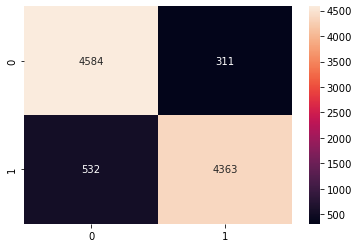

In [160]:
dt = DecisionTreeClassifier( criterion='gini',splitter = 'best',max_depth=10000, min_samples_leaf=4, min_samples_split=4)
dt.fit(Xsm_train, ysm_train)
y_dt = dt.predict(X_test)

y_dt_train =  dt.predict(Xsm_train)
y_dt_pred =  dt.predict(X_test)

cm = confusion_matrix(ysm_train, y_dt_train)
sns.heatmap(cm, annot=True, fmt='d')

In [161]:
accuracy_train = accuracy_score(ysm_train, y_dt_train)
print(f'Accuracy: {accuracy_train}')

accuracy_test = accuracy_score(y_test, y_dt_pred)
print(f'Accuracy: {accuracy_test}')

Accuracy: 0.9138917262512768
Accuracy: 0.6517739816031537


In [162]:
print(classification_report(y_test,y_dt_pred))

              precision    recall  f1-score   support

           0       0.82      0.72      0.77      1224
           1       0.24      0.37      0.30       298

    accuracy                           0.65      1522
   macro avg       0.53      0.55      0.53      1522
weighted avg       0.71      0.65      0.68      1522



Result of the decision tree are very similar to the previous ones. It seems this change is not helping my predictions. Let's try deep learning to see if the result will be better.

In [163]:
model = Sequential()

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(16,activation='relu'))
model.add(Dense(2,activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

In [164]:
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',verbose=1,
                          patience=3,restore_best_weights=True)

In [165]:
model.fit(x=Xsm_train,y=ysm_train,epochs=10,batch_size=128,
          validation_split=0.2,
         callbacks=[early_stop])

Epoch 1/10
62/62 [==============================] - 4s 17ms/step - loss: 0.6547 - accuracy: 0.6232 - val_loss: 0.8883 - val_accuracy: 0.0552
Epoch 2/10
62/62 [==============================] - 1s 12ms/step - loss: 0.6324 - accuracy: 0.6389 - val_loss: 0.8985 - val_accuracy: 0.1874
Epoch 3/10
62/62 [==============================] - 1s 15ms/step - loss: 0.6229 - accuracy: 0.6453 - val_loss: 0.8629 - val_accuracy: 0.2794
Epoch 4/10
62/62 [==============================] - 1s 16ms/step - loss: 0.6143 - accuracy: 0.6537 - val_loss: 0.8349 - val_accuracy: 0.3463
Epoch 5/10
62/62 [==============================] - 1s 16ms/step - loss: 0.6069 - accuracy: 0.6573 - val_loss: 0.8780 - val_accuracy: 0.2789
Epoch 6/10
62/62 [==============================] - 1s 12ms/step - loss: 0.6009 - accuracy: 0.6615 - val_loss: 0.8461 - val_accuracy: 0.3590
Epoch 7/10
62/62 [==============================] - 1s 13ms/step - loss: 0.5906 - accuracy: 0.6651 - val_loss: 0.8833 - val_accuracy: 0.3018
Epoch 7: earl

In [166]:
predictions_two_classes = (model.predict(X_test) > 0.5).astype("int32")
predictions_two_classes = np.argmax(predictions_two_classes, axis = 1)
predictions_two_classes

48/48 [==============================] - 0s 5ms/step


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [167]:
print(classification_report(y_test,predictions_two_classes))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1224
           1       0.26      0.22      0.24       298

    accuracy                           0.72      1522
   macro avg       0.54      0.53      0.53      1522
weighted avg       0.71      0.72      0.71      1522



The results are worse than with a larger database. Getting rid of the big part of the data was not a good idea to improve the results.

## Conclusion

Despite many tries, using diferent methods, changing the model parameters and changing the input data, I was not able to get satisfactory results. The data is imbalanced and the basic model gives back only class 0 which is the most popular. When I try to complicate it, avoid overfitting and change the input data, some results are applied to other classes but the overall accuracy is not improving. Another explanation for this is the correlation matrix, which did not find any significant correlation between cross outcome and other attributes. The assumption I made was that the cross itself has a very big impact on the outcome of the shot that comes after it. But based on the above results we can conclude that the pass recipient and the position of the defenders and goalkeeper of the opposing team are much more significant to the outcome than the cross itself. It is possible that if these data was availale and I included it in my models, they would have given a better result.